# 250610 테스트

* LangChain 기반 시스템 아키텍처 LangGraph로 구성 변경
* Agentic AI로 변경중
  -> recursion limit 오류 발생

In [16]:
import os
import re
import json
import jsonlines
from typing import Annotated, Optional, Literal, List, Dict, Any
from datetime import datetime, timedelta
import operator
from uuid import uuid4

from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_naver.embeddings import ClovaXEmbeddings
from langchain_milvus.vectorstores import Milvus
from langchain_naver.chat_models import ChatClovaX
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
    AttributeInfo,
    StructuredQueryOutputParser,
    get_query_constructor_prompt
)
from langchain.retrievers.self_query.milvus import MilvusTranslator

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, field_validator
import warnings

warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

# 기존 모델 클래스들 유지
class TimeFilter(BaseModel):
    start_date: Optional[datetime] = None
    end_date: Optional[datetime] = None

class SearchQuery(BaseModel):
    query: str
    time_filter: TimeFilter

class Label(BaseModel):
    chunk_id: int = Field(description="The unique identifier of the text chunk")
    chain_of_thought: str = Field(description="The reasoning process used to evaluate the relevance")
    relevancy: int = Field(description="Relevancy score from 0 to 10, where 10 is most relevant", ge=0, le=10)

class RerankedResults(BaseModel):
    labels: list[Label] = Field(description="List of labeled and ranked chunks")

    @field_validator("labels")
    @classmethod
    def model_validate(cls, v: list[Label]) -> list[Label]:
        return sorted(v, key=lambda x: x.relevancy, reverse=True)

# LangGraph State 정의
class AgentState(TypedDict):
    question: str
    routing_result: str
    routing_result_2: str
    expr: Optional[str]
    text_context: List[Document]
    table_context: List[Document]
    raptor_context: List[Document]
    image_context: List[Document]
    text_answer: str
    table_answer: str
    final_answer: str
    messages: Annotated[List, add_messages]

# 초기화
embeddings = ClovaXEmbeddings(model='bge-m3')
llm = ChatClovaX(model='HCX-005', temperature=0)

URI = 'http://127.0.0.1:19530'

# 데이터베이스 초기화
text_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='text_db'
)

table_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='table_db'
)

raptor_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='raptor_db'
)

image_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='image_db'
)

# BM25 리트리버 초기화
filepath_text = './chunked_jsonl/text_semantic_per_80.jsonl'
filepath_table = './chunked_jsonl/table_v7.jsonl'

def load_documents(filepath):
    docs = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('\n('):
                continue
            data = json.loads(line)
            doc = Document(
                page_content=data['page_content'],
                metadata=data['metadata']
            )
            docs.append(doc)
    return docs

splitted_doc_text = load_documents(filepath_text)
splitted_doc_table = load_documents(filepath_table)

bm25_retriever_text = KiwiBM25Retriever.from_documents(splitted_doc_text)
bm25_retriever_text.k = 50

bm25_retriever_table = KiwiBM25Retriever.from_documents(splitted_doc_table)
bm25_retriever_table.k = 20

# 유틸리티 함수들 (기존 코드 유지)
def adjust_time_filter_to_week(time_filter):
    start_date = time_filter.start_date
    end_date = time_filter.end_date

    if start_date is None or end_date is None:
        if start_date is not None and end_date is None:
            start_of_week = start_date - timedelta(days=start_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        elif end_date is not None and start_date is None:
            start_of_week = end_date - timedelta(days=end_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        else:
            return None

    if start_date.year == end_date.year and start_date.month == end_date.month and start_date.day == end_date.day:
        start_of_week = start_date - timedelta(days=start_date.weekday())
        end_of_week = start_of_week + timedelta(days=6)
        return {
            "start_date": start_of_week.replace(hour=0, minute=0, second=0),
            "end_date": end_of_week.replace(hour=23, minute=59, second=59)
        }

    return {"start_date": start_date, "end_date": end_date}

def parse_search_query_response(response: str, question: str) -> SearchQuery:
    try:
        data = json.loads(response.content)
        if data.get("time_filter") is None:
            data["time_filter"] = {}
        if "query" not in data:
            data["query"] = question
        return SearchQuery(**data)
    except Exception:
        return SearchQuery(query=question, time_filter=TimeFilter())

def format_docs(docs):
    return "\n\n".join(
        f"Issue Date: {doc.metadata.get('issue_date', 'Unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )

# LangGraph 노드 함수들
def extract_date_node(state: AgentState) -> AgentState:
    """날짜 추출 노드"""
    question = state["question"]
    today = datetime(2025, 1, 25)
    days_since_last_friday = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_since_last_friday)
    issue_date = last_friday.strftime("%Y-%m-%d")

    system_prompt = f"""
    You are an AI assistant that extracts date ranges from financial queries.
    The current report date is {issue_date}.
    Your task is to extract the relevant date or date range from the user's query
    and format it in YYYY-MM-DD format.
    If no date is specified, answer with None value.
    Return your answer as a JSON object in this format:
    {{
        "query": "<원본 질문>",
        "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} or {{"start_date": null, "end_date": null}}
    }}
    답변은 반드시 위 JSON 형태로만 해.
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
    ]
    
    response = llm.invoke(messages)
    search_query = parse_search_query_response(response, question)
    parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

    if parsed_dates:
        start = parsed_dates['start_date']
        end = parsed_dates['end_date']
        expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
    else:
        expr = None

    return {"expr": expr}

def routing_node(state: AgentState) -> AgentState:
    """라우팅 노드 - 요약/예측/일반 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''주어진 사용자 질문을 `요약`, `예측`, 또는 `일반` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result": response.content.strip()}

def routing_2_node(state: AgentState) -> AgentState:
    """라우팅 노드 2 - 날짜/호수 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''주어진 사용자 질문을 `날짜`, `호수` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result_2": response.content.strip()}

def text_retrieval_node(state: AgentState) -> AgentState:
    """텍스트 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    if expr:
        context_raw = text_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 25}
        ).invoke(question)
    else:
        context_raw = text_db.as_retriever(search_kwargs={'k': 25}).invoke(question)
    
    return {"text_context": context_raw}

def table_retrieval_node(state: AgentState) -> AgentState:
    """테이블 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    # Milvus 검색
    if expr:
        milvus_results = table_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        milvus_results = table_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
    
    # BM25 검색
    bm25_raw = bm25_retriever_table.invoke(question)
    
    # 날짜 필터링
    if expr:
        start_date = expr.split("'")[1]
        end_date = expr.split("'")[3]
        bm25_filtered = [
            doc for doc in bm25_raw
            if start_date <= doc.metadata.get("issue_date", "") <= end_date
        ]
    else:
        bm25_filtered = bm25_raw
    
    combined_context = milvus_results + bm25_filtered
    
    return {"table_context": combined_context}

def raptor_retrieval_node(state: AgentState) -> AgentState:
    """RAPTOR 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    routing_result_2 = state.get("routing_result_2", "")
    
    if '날짜' in routing_result_2.lower() and expr:
        context = raptor_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        # Self-query retriever 사용
        metadata_field_info = [
            AttributeInfo(
                name='source',
                description='문서의 번호. 네 자리의 숫자와 "호"로 이루어져 있다. 현재 1090호부터 1120호까지 존재한다.',
                type='string',
            ),
        ]
        
        prompt_query = get_query_constructor_prompt(
            'summary of weekly financial report about bonds',
            metadata_field_info
        )
        
        output_parser = StructuredQueryOutputParser.from_components()
        query_constructor = prompt_query | llm | output_parser
        
        retriever_raptor = SelfQueryRetriever(
            query_constructor=query_constructor,
            vectorstore=raptor_db,
            structured_query_translator=MilvusTranslator(),
            search_kwargs={'k': 10}
        )
        
        context = retriever_raptor.invoke(question)
    
    return {"raptor_context": context}

def text_answer_node(state: AgentState) -> AgentState:
    """텍스트 답변 생성 노드"""
    question = state["question"]
    context = state["text_context"]
    
    text_prompt = PromptTemplate.from_template(
        '''today is '2025-01-25'. You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        If question has date expressions, context already filtered with the date expression, so ignore about the date and answer without it.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {context}

        #Answer:'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": text_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"text_answer": response.content}

def table_answer_node(state: AgentState) -> AgentState:
    """테이블 답변 생성 노드"""
    question = state["question"]
    context = state["table_context"]
    
    table_prompt = PromptTemplate.from_template(
        '''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved table to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {context}

        #Answer:'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": table_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"table_answer": response.content}

def raptor_answer_node(state: AgentState) -> AgentState:
    """RAPTOR 답변 생성 노드"""
    question = state["question"]
    context = state["raptor_context"]
    
    raptor_prompt = PromptTemplate.from_template(
        '''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.
        If the context mentions an unrelated date, do not mention that part.
        Summarize and organize your answers based on the various issues that apply to the period.

        #Question:
        {question}
        #Context:
        {context}

        #Answer:'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": raptor_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response.content}

def general_answer_node(state: AgentState) -> AgentState:
    """일반 답변 생성 노드"""
    question = state["question"]
    text_answer = state["text_answer"]
    table_answer = state["table_answer"]
    
    general_prompt = PromptTemplate.from_template(
        '''You are question-answering AI chatbot about financial reports.
        주어진 두 개의 정보는 table과 text에서 가져온 정보들이야. 이 정보를 바탕으로 질문에 대해 자세히 설명해줘.
        
        If one of the table or text says it doesn't know or it can't answer, don't mention with that.
        And some questions may not be answered simply with context, but rather require inference. In those cases, answer by inference. 
        
        #Question:
        {question}

        #Text Answer:
        {text}

        #Table Answer:
        {table}
        '''
    )
    
    messages = [{"role": "user", "content": general_prompt.format(question=question, text=text_answer, table=table_answer)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response}

def predict_answer_node(state: AgentState) -> AgentState:
    """예측 답변 생성 노드 (일반 답변과 동일한 로직)"""
    return general_answer_node(state)

# 조건부 엣지 함수들
def should_use_summary(state: AgentState) -> str:
    """요약 경로인지 확인"""
    routing_result = state.get("routing_result", "").lower()
    if '요약' in routing_result:
        return "routing_2"
    elif '예측' in routing_result:
        return "predict_flow"
    else:
        return "general_flow"

def should_use_date_routing(state: AgentState) -> str:
    """날짜 기반 라우팅인지 확인"""
    routing_result_2 = state.get("routing_result_2", "").lower()
    if '날짜' in routing_result_2:
        return "raptor_answer"
    else:
        return "raptor_answer"


# 그래프 구축
def create_langgraph_agent():
    """LangGraph 에이전트 생성"""
    
    workflow = StateGraph(AgentState)
    
    # 노드 추가 (상태 키와 다른 이름 사용)
    workflow.add_node("extract_date", extract_date_node)
    workflow.add_node("routing", routing_node)
    workflow.add_node("routing_2", routing_2_node)
    workflow.add_node("text_retrieval", text_retrieval_node)
    workflow.add_node("table_retrieval", table_retrieval_node)
    workflow.add_node("raptor_retrieval", raptor_retrieval_node)
    workflow.add_node("text_answer_node", text_answer_node)
    workflow.add_node("table_answer_node", table_answer_node)
    workflow.add_node("raptor_answer_node", raptor_answer_node)
    workflow.add_node("general_answer_node", general_answer_node)
    workflow.add_node("predict_answer_node", predict_answer_node)

    def choose_final_answer(state: AgentState) -> str:
        """라우팅 결과에 따른 최종 답변 노드 선택"""
        routing_result = state.get("routing_result", "").lower()
        if '예측' in routing_result:
            return "predict_answer"
        else:
            return "general_answer"
    
    # 엣지 연결
    workflow.add_edge(START, "extract_date")
    workflow.add_edge("extract_date", "routing")
    
    workflow.add_conditional_edges(
        "routing",
        should_use_summary,
        {
            "routing_2": "routing_2",
            "predict_flow": "text_retrieval",
            "general_flow": "text_retrieval"
        }
    )
    
    workflow.add_conditional_edges(
        "routing_2",
        should_use_date_routing,
        {
            "raptor_answer": "raptor_retrieval"
        }
    )
    
    workflow.add_edge("raptor_retrieval", "raptor_answer_node")
    workflow.add_edge("raptor_answer_node", END)
    
    workflow.add_edge("text_retrieval", "table_retrieval")
    workflow.add_edge("table_retrieval", "text_answer_node")
    workflow.add_edge("text_answer_node", "table_answer_node")
    
    workflow.add_conditional_edges(
        "table_answer_node",
        choose_final_answer,
        {
            "predict_answer": "predict_answer_node",
            "general_answer": "general_answer_node"
        }
    )
    
    workflow.add_edge("general_answer_node", END)
    workflow.add_edge("predict_answer_node", END)
    
    return workflow.compile()


# 사용 예시
def ask_langgraph(question: str):
    """LangGraph 기반 질문 응답 함수"""
    agent = create_langgraph_agent()
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "messages": []
    }
    
    # 그래프 실행
    result = agent.invoke(initial_state)
    
    return result["final_answer"]

# 메인 실행 함수
if __name__ == "__main__":
    # 예시 실행
    question = "연준의 비공식 대변인은?"
    answer = ask_langgraph(question)
    print(answer)


INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"


content='연준의 비공식 대변인은 월스트리트저널(WSJ)의 닉 티미라오스(Nick Timiraos) 기자로 알려져 있습니다.\n\n이는 텍스트 답변에 명시되어 있으며, 일반적으로 금융 및 경제 분야에서 신뢰받는 출처 중 하나인 WSJ 소속 기자의 발언은 종종 중요한 인사이트를 제공하기 때문에 이러한 인식이 형성되었을 가능성이 높습니다. 다만, 공식적인 대변인 역할이 아니기 때문에 그의 의견이나 보도가 항상 연준의 입장을 대변하는 것은 아니라는 점을 유의해야 합니다.\n\n한편, 테이블 답변에서는 해당 정보가 제공되지 않아 답변을 드릴 수 없다고 나와있습니다. 이는 테이블에 저장된 특정 데이터베이스나 정보 소스에서 연준의 비공식 대변인에 관한 세부 사항을 찾을 수 없음을 의미하며, 이 경우 외부 출처를 통해 얻은 지식을 활용하여 답변을 제공하는 것이 적절하다고 판단됩니다.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 187, 'prompt_tokens': 188, 'total_tokens': 375, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'HCX-005', 'system_fingerprint': None, 'id': '135188c6677343ad88d028df05fd441c', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--4c02f8bf-667e-406b-a9b6-237057a9d703-0' usage_metadata={'input_tokens': 188, 'output_tokens': 187, 'total_tokens': 375, 'input_token_details': {}, 'output_token_details': {}}


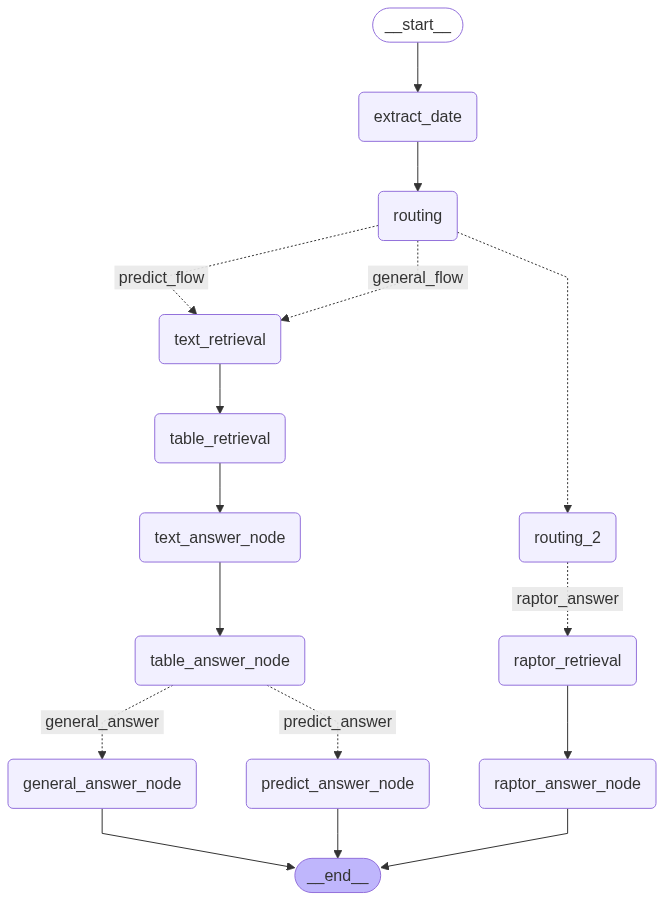

In [4]:
create_langgraph_agent()

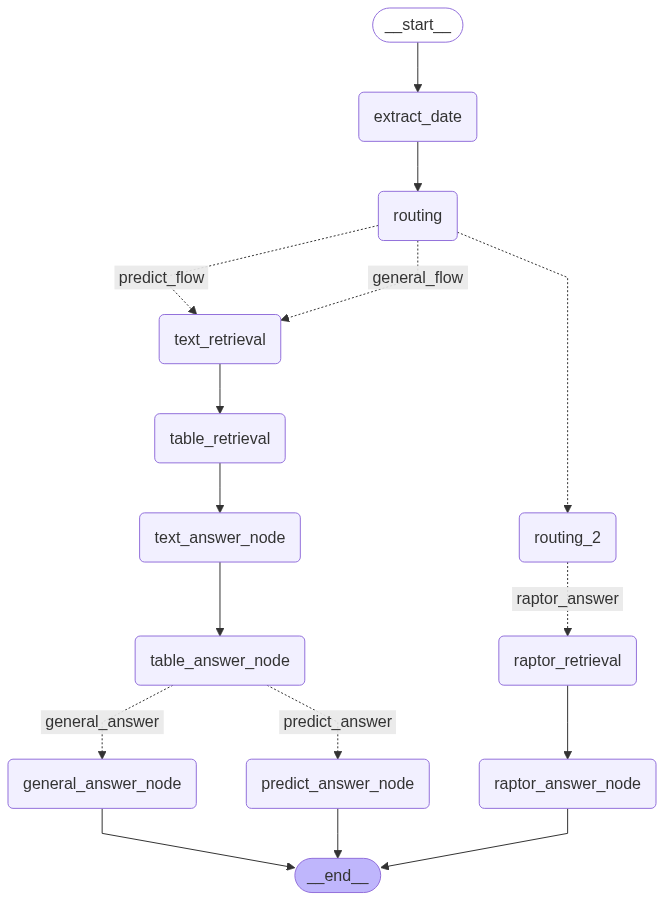

In [5]:
from IPython.display import Image, display

display(Image(create_langgraph_agent().get_graph().draw_mermaid_png()))

In [ ]:
import os
import re
import json
import jsonlines
from typing import Annotated, Optional, Literal, List, Dict, Any
from datetime import datetime, timedelta
import operator
from uuid import uuid4

from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_naver.embeddings import ClovaXEmbeddings
from langchain_milvus.vectorstores import Milvus
from langchain_naver.chat_models import ChatClovaX
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
    AttributeInfo,
    StructuredQueryOutputParser,
    get_query_constructor_prompt
)
from langchain.retrievers.self_query.milvus import MilvusTranslator

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, field_validator
import warnings

warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

# ---------- Agentic AI State 정의 ----------
class AgenticState(TypedDict):
    # 사용자 입력
    question: str
    
    # Agentic AI 핵심 요소
    goal: str
    plan: List[str]
    current_step: int
    execution_log: List[Dict[str, Any]]
    reflection: Optional[str]
    confidence_score: float
    retry_count: int
    max_retries: int
    
    # 도구 및 검색 결과
    available_tools: List[str]
    selected_tools: List[str]
    
    # 기존 RAG 요소들
    routing_result: str
    routing_result_2: str
    expr: Optional[str]
    text_context: List[Document]
    table_context: List[Document]
    raptor_context: List[Document]
    image_context: List[Document]
    text_answer: str
    table_answer: str
    final_answer: str
    
    # 메시지 및 메타데이터
    messages: Annotated[List, add_messages]
    session_id: str
    timestamp: datetime

# ---------- 기존 모델 클래스들 유지 ----------
class TimeFilter(BaseModel):
    start_date: Optional[datetime] = None
    end_date: Optional[datetime] = None

class SearchQuery(BaseModel):
    query: str
    time_filter: TimeFilter

class Label(BaseModel):
    chunk_id: int = Field(description="The unique identifier of the text chunk")
    chain_of_thought: str = Field(description="The reasoning process used to evaluate the relevance")
    relevancy: int = Field(description="Relevancy score from 0 to 10, where 10 is most relevant", ge=0, le=10)

class RerankedResults(BaseModel):
    labels: list[Label] = Field(description="List of labeled and ranked chunks")

    @field_validator("labels")
    @classmethod
    def model_validate(cls, v: list[Label]) -> list[Label]:
        return sorted(v, key=lambda x: x.relevancy, reverse=True)

# ---------- 초기화 ----------
embeddings = ClovaXEmbeddings(model='bge-m3')
llm = ChatClovaX(model='HCX-005', temperature=0)
planning_llm = ChatClovaX(model='HCX-005', temperature=0.3)  # 계획 수립용 LLM

URI = 'http://127.0.0.1:19530'

# 데이터베이스 초기화
text_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='text_db'
)

table_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='table_db'
)

raptor_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='raptor_db'
)

image_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='image_db'
)

# BM25 리트리버 초기화
filepath_text = './chunked_jsonl/text_semantic_per_80.jsonl'
filepath_table = './chunked_jsonl/table_v7.jsonl'

def load_documents(filepath):
    docs = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith('\n('):
                continue
            data = json.loads(line)
            doc = Document(
                page_content=data['page_content'],
                metadata=data['metadata']
            )
            docs.append(doc)
    return docs

splitted_doc_text = load_documents(filepath_text)
splitted_doc_table = load_documents(filepath_table)

bm25_retriever_text = KiwiBM25Retriever.from_documents(splitted_doc_text)
bm25_retriever_text.k = 50

bm25_retriever_table = KiwiBM25Retriever.from_documents(splitted_doc_table)
bm25_retriever_table.k = 20

# ---------- 유틸리티 함수들 ----------
def adjust_time_filter_to_week(time_filter):
    start_date = time_filter.start_date
    end_date = time_filter.end_date

    if start_date is None or end_date is None:
        if start_date is not None and end_date is None:
            start_of_week = start_date - timedelta(days=start_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        elif end_date is not None and start_date is None:
            start_of_week = end_date - timedelta(days=end_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        else:
            return None

    if start_date.year == end_date.year and start_date.month == end_date.month and start_date.day == end_date.day:
        start_of_week = start_date - timedelta(days=start_date.weekday())
        end_of_week = start_of_week + timedelta(days=6)
        return {
            "start_date": start_of_week.replace(hour=0, minute=0, second=0),
            "end_date": end_of_week.replace(hour=23, minute=59, second=59)
        }

    return {"start_date": start_date, "end_date": end_date}

def parse_search_query_response(response: str, question: str) -> SearchQuery:
    try:
        data = json.loads(response.content)
        if data.get("time_filter") is None:
            data["time_filter"] = {}
        if "query" not in data:
            data["query"] = question
        return SearchQuery(**data)
    except Exception:
        return SearchQuery(query=question, time_filter=TimeFilter())

def format_docs(docs):
    return "\n\n".join(
        f"Issue Date: {doc.metadata.get('issue_date', 'Unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )

# ---------- Agentic AI 노드들 ----------

def goal_setting_node(state: AgenticState) -> AgenticState:
    """목표 설정 및 초기화 노드"""
    question = state["question"]
    
    goal_prompt = f"""
    사용자의 질문을 분석하여 명확한 목표를 설정하세요.
    질문: {question}
    
    다음 형식으로 목표를 설정하세요:
    - 주요 목표: [구체적인 목표]
    - 성공 기준: [답변의 품질 기준]
    - 예상 복잡도: [1-5 점수]
    """
    
    messages = [{"role": "user", "content": goal_prompt}]
    response = planning_llm.invoke(messages)
    
    # 사용 가능한 도구 목록 정의
    available_tools = [
        "date_extraction",
        "question_routing", 
        "text_search",
        "table_search",
        "raptor_search",
        "answer_generation"
    ]
    
    return {
        "goal": response.content,
        "available_tools": available_tools,
        "current_step": 0,
        "execution_log": [],
        "confidence_score": 0.0,
        "retry_count": 0,
        "max_retries": 3,
        "session_id": str(uuid4()),
        "timestamp": datetime.now()
    }

def planning_node(state: AgenticState) -> AgenticState:
    """동적 계획 수립 노드"""
    question = state["question"]
    goal = state["goal"]
    retry_count = state.get("retry_count", 0)
    
    planning_prompt = f"""
    목표: {goal}
    질문: {question}
    재시도 횟수: {retry_count}
    
    다음 단계들 중에서 필요한 것들을 순서대로 선택하여 계획을 수립하세요:
    1. date_extraction - 날짜 정보 추출
    2. question_routing - 질문 유형 분류 (요약/예측/일반)
    3. secondary_routing - 세부 라우팅 (날짜/호수)
    4. text_search - 텍스트 검색
    5. table_search - 테이블 검색  
    6. raptor_search - RAPTOR 검색
    7. answer_generation - 답변 생성
    8. quality_check - 품질 검증
    
    JSON 형식으로 계획을 반환하세요:
    {{"plan": ["step1", "step2", ...], "reasoning": "계획 수립 이유"}}
    """
    
    messages = [{"role": "user", "content": planning_prompt}]
    response = planning_llm.invoke(messages)
    
    try:
        plan_data = json.loads(response.content)
        plan = plan_data.get("plan", [
            "date_extraction", "question_routing", "text_search", 
            "table_search", "answer_generation", "quality_check"
        ])
    except:
        # 기본 계획
        plan = [
            "date_extraction", "question_routing", "text_search", 
            "table_search", "answer_generation", "quality_check"
        ]
    
    return {
        "plan": plan,
        "current_step": 0,
        "execution_log": [{"action": "planning", "result": "계획 수립 완료", "timestamp": datetime.now()}]
    }

def execution_node(state: AgenticState) -> AgenticState:
    """실행 노드 - 현재 계획 단계 실행"""
    plan = state["plan"]
    current_step = state["current_step"]
    execution_log = state["execution_log"]
    
    if current_step >= len(plan):
        return {"execution_log": execution_log + [{"action": "execution", "result": "모든 단계 완료", "timestamp": datetime.now()}]}
    
    step = plan[current_step]
    log_entry = {"action": step, "timestamp": datetime.now()}
    
    try:
        if step == "date_extraction":
            result = extract_date_node(state)
            state.update(result)
            log_entry["result"] = "날짜 추출 완료"
            log_entry["details"] = {"expr": result.get("expr")}
            
        elif step == "question_routing":
            result = routing_node(state)
            state.update(result)
            log_entry["result"] = "질문 라우팅 완료"
            log_entry["details"] = {"routing": result.get("routing_result")}
            
        elif step == "secondary_routing":
            result = routing_2_node(state)
            state.update(result)
            log_entry["result"] = "세부 라우팅 완료"
            log_entry["details"] = {"routing_2": result.get("routing_result_2")}
            
        elif step == "text_search":
            result = text_retrieval_node(state)
            state.update(result)
            log_entry["result"] = "텍스트 검색 완료"
            log_entry["details"] = {"context_count": len(result.get("text_context", []))}
            
        elif step == "table_search":
            result = table_retrieval_node(state)
            state.update(result)
            log_entry["result"] = "테이블 검색 완료"
            log_entry["details"] = {"context_count": len(result.get("table_context", []))}
            
        elif step == "raptor_search":
            result = raptor_retrieval_node(state)
            state.update(result)
            log_entry["result"] = "RAPTOR 검색 완료"
            log_entry["details"] = {"context_count": len(result.get("raptor_context", []))}
            
        elif step == "answer_generation":
            routing_result = state.get("routing_result", "").lower()
            if "요약" in routing_result:
                result = raptor_answer_node(state)
            elif "예측" in routing_result:
                text_result = text_answer_node(state)
                table_result = table_answer_node({**state, **text_result})
                result = general_answer_node({**state, **text_result, **table_result})
            else:
                text_result = text_answer_node(state)
                table_result = table_answer_node({**state, **text_result})
                result = general_answer_node({**state, **text_result, **table_result})
            
            state.update(result)
            log_entry["result"] = "답변 생성 완료"
            log_entry["details"] = {"answer_length": len(result.get("final_answer", ""))}
            
        elif step == "quality_check":
            result = quality_check_node(state)
            state.update(result)
            log_entry["result"] = "품질 검증 완료"
            log_entry["details"] = {"confidence": result.get("confidence_score", 0)}
            
        else:
            log_entry["result"] = f"알 수 없는 단계: {step}"
            
    except Exception as e:
        log_entry["result"] = f"실행 오류: {str(e)}"
        log_entry["error"] = True
    
    execution_log.append(log_entry)
    
    return {
        "execution_log": execution_log,
        "current_step": current_step + 1
    }

def quality_check_node(state: AgenticState) -> AgenticState:
    """품질 검증 및 신뢰도 평가 노드"""
    final_answer = state.get("final_answer", "")
    question = state["question"]
    
    quality_prompt = f"""
    질문: {question}
    생성된 답변: {final_answer}
    
    다음 기준으로 답변의 품질을 평가하세요:
    1. 관련성 (질문과의 연관성)
    2. 완성도 (답변의 충분함)
    3. 정확성 (정보의 신뢰성)
    4. 명확성 (이해하기 쉬운 정도)
    
    JSON 형식으로 평가 결과를 반환하세요:
    {{
        "confidence_score": 0.0-1.0,
        "quality_issues": ["문제점1", "문제점2", ...],
        "improvement_suggestions": ["개선사항1", "개선사항2", ...],
        "needs_retry": true/false
    }}
    """
    
    messages = [{"role": "user", "content": quality_prompt}]
    response = llm.invoke(messages)
    
    try:
        quality_data = json.loads(response.content)
        confidence_score = quality_data.get("confidence_score", 0.7)
        needs_retry = quality_data.get("needs_retry", False)
        
        if confidence_score < 0.6 or needs_retry:
            reflection = f"품질 점수가 낮음 ({confidence_score}). 개선 필요."
        else:
            reflection = None
            
    except:
        confidence_score = 0.7
        reflection = None
    
    return {
        "confidence_score": confidence_score,
        "reflection": reflection
    }

def reflection_node(state: AgenticState) -> AgenticState:
    """반성 및 재계획 노드"""
    reflection = state.get("reflection")
    retry_count = state.get("retry_count", 0)
    max_retries = state.get("max_retries", 3)
    execution_log = state.get("execution_log", [])
    
    if not reflection or retry_count >= max_retries:
        return {"reflection": None}
    
    reflection_prompt = f"""
    현재 문제: {reflection}
    실행 로그: {execution_log[-3:]}  # 최근 3개 로그만
    재시도 횟수: {retry_count}/{max_retries}
    
    문제를 해결하기 위한 새로운 계획을 수립하세요.
    이전 실행에서 무엇이 잘못되었는지 분석하고 개선 방안을 제시하세요.
    
    JSON 형식으로 반환:
    {{
        "new_plan": ["step1", "step2", ...],
        "changes_made": "변경사항 설명",
        "expected_improvement": "기대 효과"
    }}
    """
    
    messages = [{"role": "user", "content": reflection_prompt}]
    response = planning_llm.invoke(messages)
    
    try:
        reflection_data = json.loads(response.content)
        new_plan = reflection_data.get("new_plan", state["plan"])
    except:
        # 기본적으로 검색 단계를 강화
        new_plan = [
            "date_extraction", "question_routing", "secondary_routing",
            "text_search", "table_search", "raptor_search", 
            "answer_generation", "quality_check"
        ]
    
    return {
        "plan": new_plan,
        "current_step": 0,
        "retry_count": retry_count + 1,
        "reflection": None,
        "execution_log": execution_log + [{
            "action": "reflection", 
            "result": "재계획 완료", 
            "timestamp": datetime.now()
        }]
    }

def monitoring_node(state: AgenticState) -> AgenticState:
    """모니터링 및 로깅 노드"""
    execution_log = state.get("execution_log", [])
    confidence_score = state.get("confidence_score", 0)
    
    # 실행 통계 계산
    total_steps = len(execution_log)
    error_count = sum(1 for log in execution_log if log.get("error", False))
    success_rate = (total_steps - error_count) / total_steps if total_steps > 0 else 0
    
    monitoring_data = {
        "total_steps": total_steps,
        "error_count": error_count,
        "success_rate": success_rate,
        "confidence_score": confidence_score,
        "timestamp": datetime.now()
    }
    
    # 로그에 모니터링 정보 추가
    execution_log.append({
        "action": "monitoring",
        "result": "모니터링 완료",
        "details": monitoring_data,
        "timestamp": datetime.now()
    })
    
    return {"execution_log": execution_log}

# ---------- 기존 RAG 노드들 (재사용) ----------

def extract_date_node(state: AgenticState) -> AgenticState:
    """날짜 추출 노드"""
    question = state["question"]
    today = datetime(2025, 1, 25)
    days_since_last_friday = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_since_last_friday)
    issue_date = last_friday.strftime("%Y-%m-%d")

    system_prompt = f"""
    You are an AI assistant that extracts date ranges from financial queries.
    The current report date is {issue_date}.
    Your task is to extract the relevant date or date range from the user's query
    and format it in YYYY-MM-DD format.
    If no date is specified, answer with None value.
    Return your answer as a JSON object in this format:
    {{
        "query": "<원본 질문>",
        "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} or {{"start_date": null, "end_date": null}}
    }}
    답변은 반드시 위 JSON 형태로만 해.
    """

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
    ]
    
    response = llm.invoke(messages)
    search_query = parse_search_query_response(response, question)
    parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

    if parsed_dates:
        start = parsed_dates['start_date']
        end = parsed_dates['end_date']
        expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
    else:
        expr = None

    return {"expr": expr}

def routing_node(state: AgenticState) -> AgenticState:
    """라우팅 노드 - 요약/예측/일반 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''주어진 사용자 질문을 `요약`, `예측`, 또는 `일반` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result": response.content.strip()}

def routing_2_node(state: AgenticState) -> AgenticState:
    """라우팅 노드 2 - 날짜/호수 분류"""
    question = state["question"]
    
    prompt = PromptTemplate.from_template(
        '''주어진 사용자 질문을 `날짜`, `호수` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
    )
    
    messages = [{"role": "user", "content": prompt.format(question=question)}]
    response = llm.invoke(messages)
    
    return {"routing_result_2": response.content.strip()}

def text_retrieval_node(state: AgenticState) -> AgenticState:
    """텍스트 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    if expr:
        context_raw = text_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 25}
        ).invoke(question)
    else:
        context_raw = text_db.as_retriever(search_kwargs={'k': 25}).invoke(question)
    
    return {"text_context": context_raw}

def table_retrieval_node(state: AgenticState) -> AgenticState:
    """테이블 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    
    # Milvus 검색
    if expr:
        milvus_results = table_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        milvus_results = table_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
    
    # BM25 검색
    bm25_raw = bm25_retriever_table.invoke(question)
    
    # 날짜 필터링
    if expr:
        start_date = expr.split("'")[1]
        end_date = expr.split("'")[3]
        bm25_filtered = [
            doc for doc in bm25_raw
            if start_date <= doc.metadata.get("issue_date", "") <= end_date
        ]
    else:
        bm25_filtered = bm25_raw
    
    combined_context = milvus_results + bm25_filtered
    
    return {"table_context": combined_context}

def raptor_retrieval_node(state: AgenticState) -> AgenticState:
    """RAPTOR 검색 노드"""
    question = state["question"]
    expr = state.get("expr")
    routing_result_2 = state.get("routing_result_2", "")
    
    if '날짜' in routing_result_2.lower() and expr:
        context = raptor_db.as_retriever(
            search_kwargs={'expr': expr, 'k': 10}
        ).invoke(question)
    else:
        # Self-query retriever 사용
        metadata_field_info = [
            AttributeInfo(
                name='source',
                description='문서의 번호. 네 자리의 숫자와 "호"로 이루어져 있다. 현재 1090호부터 1120호까지 존재한다.',
                type='string',
            ),
        ]
        
        prompt_query = get_query_constructor_prompt(
            'summary of weekly financial report about bonds',
            metadata_field_info
        )
        
        output_parser = StructuredQueryOutputParser.from_components()
        query_constructor = prompt_query | llm | output_parser
        
        retriever_raptor = SelfQueryRetriever(
            query_constructor=query_constructor,
            vectorstore=raptor_db,
            structured_query_translator=MilvusTranslator(),
            search_kwargs={'k': 10}
        )
        
        context = retriever_raptor.invoke(question)
    
    return {"raptor_context": context}

def text_answer_node(state: AgenticState) -> AgenticState:
    """텍스트 답변 생성 노드"""
    question = state["question"]
    context = state["text_context"]
    
    text_prompt = PromptTemplate.from_template(
        '''today is '2025-01-25'. You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        If question has date expressions, context already filtered with the date expression, so ignore about the date and answer without it.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {context}

        #Answer:'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": text_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"text_answer": response.content}

def table_answer_node(state: AgenticState) -> AgenticState:
    """테이블 답변 생성 노드"""
    question = state["question"]
    context = state["table_context"]
    
    table_prompt = PromptTemplate.from_template(
        '''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved table to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {context}

        #Answer:'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": table_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"table_answer": response.content}

def raptor_answer_node(state: AgenticState) -> AgenticState:
    """RAPTOR 답변 생성 노드"""
    question = state["question"]
    context = state["raptor_context"]
    
    raptor_prompt = PromptTemplate.from_template(
        '''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.
        If the context mentions an unrelated date, do not mention that part.
        Summarize and organize your answers based on the various issues that apply to the period.

        #Question:
        {question}
        #Context:
        {context}

        #Answer:'''
    )
    
    formatted_context = format_docs(context)
    messages = [{"role": "user", "content": raptor_prompt.format(question=question, context=formatted_context)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response.content}

def general_answer_node(state: AgenticState) -> AgenticState:
    """일반 답변 생성 노드"""
    question = state["question"]
    text_answer = state["text_answer"]
    table_answer = state["table_answer"]
    
    general_prompt = PromptTemplate.from_template(
        '''You are question-answering AI chatbot about financial reports.
        주어진 두 개의 정보는 table과 text에서 가져온 정보들이야. 이 정보를 바탕으로 질문에 대해 자세히 설명해줘.
        
        If one of the table or text says it doesn't know or it can't answer, don't mention with that.
        And some questions may not be answered simply with context, but rather require inference. In those cases, answer by inference. 
        
        #Question:
        {question}

        #Text Answer:
        {text}

        #Table Answer:
        {table}
        '''
    )
    
    messages = [{"role": "user", "content": general_prompt.format(question=question, text=text_answer, table=table_answer)}]
    response = llm.invoke(messages)
    
    return {"final_answer": response.content}

# ---------- Agentic AI 그래프 구축 ----------

def create_agentic_agent():
    """완전한 Agentic AI 에이전트 생성"""
    
    workflow = StateGraph(AgenticState)
    
    # Agentic AI 노드들 추가
    workflow.add_node("goal_setting", goal_setting_node)
    workflow.add_node("planning", planning_node)
    workflow.add_node("execution", execution_node)
    workflow.add_node("quality_check", quality_check_node)
    workflow.add_node("reflection_node", reflection_node)  # 상태 키와 다른 이름 사용
    workflow.add_node("monitoring", monitoring_node)
    
    # 조건부 엣지 함수들
    def should_continue_execution(state: AgenticState) -> str:
        """실행을 계속할지 결정"""
        current_step = state.get("current_step", 0)
        plan = state.get("plan", [])
        
        if current_step < len(plan):
            return "continue"
        else:
            return "quality_check"
    
    def should_reflect(state: AgenticState) -> str:
        """반성이 필요한지 결정"""
        reflection = state.get("reflection")
        retry_count = state.get("retry_count", 0)
        max_retries = state.get("max_retries", 3)
        
        if reflection and retry_count < max_retries:
            return "reflect"
        else:
            return "monitor"
    
    def should_end(state: AgenticState) -> str:
        """종료할지 결정"""
        confidence_score = state.get("confidence_score", 0)
        retry_count = state.get("retry_count", 0)
        max_retries = state.get("max_retries", 3)
        
        if confidence_score >= 0.6 or retry_count >= max_retries:
            return "end"
        else:
            return "continue"
    
    # 워크플로우 구성
    workflow.add_edge(START, "goal_setting")
    workflow.add_edge("goal_setting", "planning")
    workflow.add_edge("planning", "execution")
    
    # 실행 루프
    workflow.add_conditional_edges(
        "execution",
        should_continue_execution,
        {
            "continue": "execution",
            "quality_check": "quality_check"
        }
    )
    
    # 품질 검증 후 반성 여부 결정
    workflow.add_conditional_edges(
        "quality_check",
        should_reflect,
        {
            "reflect": "reflection_node",  # 변경된 노드 이름 사용
            "monitor": "monitoring"
        }
    )
    
    # 반성 후 재계획
    workflow.add_edge("reflection_node", "planning")  # 변경된 노드 이름 사용
    
    # 모니터링 후 종료 여부 결정
    workflow.add_conditional_edges(
        "monitoring",
        should_end,
        {
            "end": END,
            "continue": "planning"
        }
    )
    
    return workflow.compile()

# ---------- 사용 인터페이스 ----------

def ask_agentic_ai(question: str, session_id: Optional[str] = None):
    """Agentic AI 기반 질문 응답 함수"""
    agent = create_agentic_agent()
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "goal": "",
        "plan": [],
        "current_step": 0,
        "execution_log": [],
        "reflection": None,
        "confidence_score": 0.0,
        "retry_count": 0,
        "max_retries": 3,
        "available_tools": [],
        "selected_tools": [],
        "routing_result": "",
        "routing_result_2": "",
        "expr": None,
        "text_context": [],
        "table_context": [],
        "raptor_context": [],
        "image_context": [],
        "text_answer": "",
        "table_answer": "",
        "final_answer": "",
        "messages": [],
        "session_id": session_id or str(uuid4()),
        "timestamp": datetime.now()
    }
    
    # 그래프 실행
    result = agent.invoke(initial_state)
    
    return {
        "answer": result.get("final_answer", "답변을 생성할 수 없습니다."),
        "confidence": result.get("confidence_score", 0),
        "execution_log": result.get("execution_log", []),
        "session_id": result.get("session_id"),
        "goal": result.get("goal", ""),
        "plan": result.get("plan", [])
    }

# 메인 실행 함수
if __name__ == "__main__":
    # 예시 실행
    question = "연준의 비공식 대변인은?"
    result = ask_agentic_ai(question)
    
    print(f"답변: {result['answer']}")
    print(f"신뢰도: {result['confidence']}")
    print(f"목표: {result['goal']}")
    print(f"계획: {result['plan']}")
    print(f"실행 로그: {len(result['execution_log'])}개 단계")


답변: 
신뢰도: 0.7
목표: 주요 목표: 연방준비제도(연준)의 비공식 대변인에 대한 정보를 제공

성공 기준: 
- 답변은 질문에 직접적으로 대답해야 합니다.
- 답변에는 해당 인물의 이름, 역할 및 그들이 어떻게 비공식 대변인으로 간주되는지에 대한 간략한 설명이 포함되어야 합니다.
- 가능하다면, 그들의 배경 정보와 그들이 대변인 역할을 수행하는 데 영향을 미치는 요인들을 언급합니다.

예상 복잡도: 3점

이유: 이 질문은 특정 기관과 관련된 인물에 대해 묻고 있으며, 이에 대한 정보는 금융 뉴스나 경제 관련 자료에서 찾을 수 있습니다. 그러나 공식 대변인과 달리 비공식 대변인은 명확하게 정의되지 않을 수 있으므로 약간의 조사와 이해가 필요할 수 있습니다. 따라서 중간 정도의 복잡도를 가진다고 판단됩니다.
계획: ['date_extraction', 'question_routing', 'text_search', 'table_search', 'answer_generation', 'quality_check']
실행 로그: 8개 단계


In [14]:
import os
import re
import json
import jsonlines
from typing import Annotated, Optional, Literal, List, Dict, Any
from datetime import datetime, timedelta
import operator
from uuid import uuid4

from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_naver.embeddings import ClovaXEmbeddings
from langchain_milvus.vectorstores import Milvus
from langchain_naver.chat_models import ChatClovaX
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
    AttributeInfo,
    StructuredQueryOutputParser,
    get_query_constructor_prompt
)
from langchain.retrievers.self_query.milvus import MilvusTranslator

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, field_validator
import warnings
import logging

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from dotenv import load_dotenv
load_dotenv()

# ---------- Agentic AI State 정의 ----------
class AgenticState(TypedDict):
    # 사용자 입력
    question: str
    
    # Agentic AI 핵심 요소
    goal: str
    plan: List[str]
    current_step: int
    execution_log: List[Dict[str, Any]]
    reflection: Optional[str]
    confidence_score: float
    retry_count: int
    max_retries: int
    
    # 도구 및 검색 결과
    available_tools: List[str]
    selected_tools: List[str]
    
    # 기존 RAG 요소들
    routing_result: str
    routing_result_2: str
    expr: Optional[str]
    text_context: List[Document]
    table_context: List[Document]
    raptor_context: List[Document]
    image_context: List[Document]
    text_answer: str
    table_answer: str
    final_answer: str
    
    # 메시지 및 메타데이터
    messages: Annotated[List, add_messages]
    session_id: str
    timestamp: datetime

# ---------- 기존 모델 클래스들 유지 ----------
class TimeFilter(BaseModel):
    start_date: Optional[datetime] = None
    end_date: Optional[datetime] = None

class SearchQuery(BaseModel):
    query: str
    time_filter: TimeFilter

class Label(BaseModel):
    chunk_id: int = Field(description="The unique identifier of the text chunk")
    chain_of_thought: str = Field(description="The reasoning process used to evaluate the relevance")
    relevancy: int = Field(description="Relevancy score from 0 to 10, where 10 is most relevant", ge=0, le=10)

class RerankedResults(BaseModel):
    labels: list[Label] = Field(description="List of labeled and ranked chunks")

    @field_validator("labels")
    @classmethod
    def model_validate(cls, v: list[Label]) -> list[Label]:
        return sorted(v, key=lambda x: x.relevancy, reverse=True)

# ---------- 초기화 ----------
embeddings = ClovaXEmbeddings(model='bge-m3')
llm = ChatClovaX(model='HCX-005', temperature=0)
planning_llm = ChatClovaX(model='HCX-005', temperature=0.3)

URI = 'http://127.0.0.1:19530'

# 데이터베이스 초기화
text_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='text_db'
)

table_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='table_db'
)

raptor_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='raptor_db'
)

image_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='image_db'
)

# BM25 리트리버 초기화
filepath_text = './chunked_jsonl/text_semantic_per_80.jsonl'
filepath_table = './chunked_jsonl/table_v7.jsonl'

def load_documents(filepath):
    docs = []
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('\n('):
                    continue
                data = json.loads(line)
                doc = Document(
                    page_content=data['page_content'],
                    metadata=data['metadata']
                )
                docs.append(doc)
    except Exception as e:
        logger.error(f"Failed to load documents from {filepath}: {e}")
        return []
    return docs

splitted_doc_text = load_documents(filepath_text)
splitted_doc_table = load_documents(filepath_table)

if splitted_doc_text:
    bm25_retriever_text = KiwiBM25Retriever.from_documents(splitted_doc_text)
    bm25_retriever_text.k = 50
else:
    bm25_retriever_text = None

if splitted_doc_table:
    bm25_retriever_table = KiwiBM25Retriever.from_documents(splitted_doc_table)
    bm25_retriever_table.k = 20
else:
    bm25_retriever_table = None

# ---------- 유틸리티 함수들 ----------
def safe_invoke_llm(messages, default_response="답변을 생성할 수 없습니다."):
    """LLM 호출을 안전하게 처리하는 함수"""
    try:
        response = llm.invoke(messages)
        return response.content if hasattr(response, 'content') else str(response)
    except Exception as e:
        logger.error(f"LLM 호출 실패: {e}")
        return default_response

def adjust_time_filter_to_week(time_filter):
    start_date = time_filter.start_date
    end_date = time_filter.end_date

    if start_date is None or end_date is None:
        if start_date is not None and end_date is None:
            start_of_week = start_date - timedelta(days=start_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        elif end_date is not None and start_date is None:
            start_of_week = end_date - timedelta(days=end_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        else:
            return None

    if start_date.year == end_date.year and start_date.month == end_date.month and start_date.day == end_date.day:
        start_of_week = start_date - timedelta(days=start_date.weekday())
        end_of_week = start_of_week + timedelta(days=6)
        return {
            "start_date": start_of_week.replace(hour=0, minute=0, second=0),
            "end_date": end_of_week.replace(hour=23, minute=59, second=59)
        }

    return {"start_date": start_date, "end_date": end_date}

def parse_search_query_response(response: str, question: str) -> SearchQuery:
    try:
        if hasattr(response, 'content'):
            content = response.content
        else:
            content = str(response)
        data = json.loads(content)
        if data.get("time_filter") is None:
            data["time_filter"] = {}
        if "query" not in data:
            data["query"] = question
        return SearchQuery(**data)
    except Exception as e:
        logger.error(f"검색 쿼리 파싱 실패: {e}")
        return SearchQuery(query=question, time_filter=TimeFilter())

def format_docs(docs):
    if not docs:
        return "관련 문서를 찾을 수 없습니다."
    return "\n\n".join(
        f"Issue Date: {doc.metadata.get('issue_date', 'Unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )

# ---------- Agentic AI 노드들 ----------

def goal_setting_node(state: AgenticState) -> AgenticState:
    """목표 설정 및 초기화 노드"""
    question = state["question"]
    
    goal_prompt = f"""
    사용자의 질문을 분석하여 명확한 목표를 설정하세요.
    질문: {question}
    
    다음 형식으로 목표를 설정하세요:
    - 주요 목표: [구체적인 목표]
    - 성공 기준: [답변의 품질 기준]
    - 예상 복잡도: [1-5 점수]
    """
    
    messages = [{"role": "user", "content": goal_prompt}]
    goal_response = safe_invoke_llm(messages, "목표 설정 실패")
    
    available_tools = [
        "date_extraction",
        "question_routing", 
        "text_search",
        "table_search",
        "raptor_search",
        "answer_generation"
    ]
    
    return {
        "goal": goal_response,
        "available_tools": available_tools,
        "current_step": 0,
        "execution_log": [{
            "action": "goal_setting", 
            "result": "목표 설정 완료", 
            "timestamp": datetime.now()
        }],
        "confidence_score": 0.0,
        "retry_count": 0,
        "max_retries": 3,
        "session_id": str(uuid4()),
        "timestamp": datetime.now()
    }

def planning_node(state: AgenticState) -> AgenticState:
    """동적 계획 수립 노드"""
    question = state["question"]
    goal = state["goal"]
    retry_count = state.get("retry_count", 0)
    
    planning_prompt = f"""
    목표: {goal}
    질문: {question}
    재시도 횟수: {retry_count}
    
    다음 단계들 중에서 필요한 것들을 순서대로 선택하여 계획을 수립하세요:
    1. date_extraction - 날짜 정보 추출
    2. question_routing - 질문 유형 분류 (요약/예측/일반)
    3. secondary_routing - 세부 라우팅 (날짜/호수)
    4. text_search - 텍스트 검색
    5. table_search - 테이블 검색  
    6. raptor_search - RAPTOR 검색
    7. answer_generation - 답변 생성
    8. quality_check - 품질 검증
    
    JSON 형식으로 계획을 반환하세요:
    {{"plan": ["step1", "step2", ...], "reasoning": "계획 수립 이유"}}
    """
    
    messages = [{"role": "user", "content": planning_prompt}]
    response = safe_invoke_llm(messages)
    
    try:
        plan_data = json.loads(response)
        plan = plan_data.get("plan", [
            "date_extraction", "question_routing", "text_search", 
            "table_search", "answer_generation", "quality_check"
        ])
    except:
        plan = [
            "date_extraction", "question_routing", "text_search", 
            "table_search", "answer_generation", "quality_check"
        ]
    
    execution_log = state.get("execution_log", [])
    execution_log.append({
        "action": "planning", 
        "result": "계획 수립 완료", 
        "details": {"plan": plan},
        "timestamp": datetime.now()
    })
    
    return {
        "plan": plan,
        "current_step": 0,
        "execution_log": execution_log
    }

def execution_node(state: AgenticState) -> AgenticState:
    """실행 노드 - 현재 계획 단계 실행"""
    plan = state["plan"]
    current_step = state["current_step"]
    execution_log = state.get("execution_log", [])
    
    if current_step >= len(plan):
        execution_log.append({
            "action": "execution", 
            "result": "모든 단계 완료", 
            "timestamp": datetime.now()
        })
        return {"execution_log": execution_log}
    
    step = plan[current_step]
    log_entry = {"action": step, "timestamp": datetime.now()}
    
    try:
        if step == "date_extraction":
            result = extract_date_node(state)
            state.update(result)
            log_entry["result"] = "날짜 추출 완료"
            log_entry["details"] = {"expr": result.get("expr")}
            
        elif step == "question_routing":
            result = routing_node(state)
            state.update(result)
            log_entry["result"] = "질문 라우팅 완료"
            log_entry["details"] = {"routing": result.get("routing_result")}
            
        elif step == "secondary_routing":
            result = routing_2_node(state)
            state.update(result)
            log_entry["result"] = "세부 라우팅 완료"
            log_entry["details"] = {"routing_2": result.get("routing_result_2")}
            
        elif step == "text_search":
            result = text_retrieval_node(state)
            state.update(result)
            log_entry["result"] = "텍스트 검색 완료"
            log_entry["details"] = {"context_count": len(result.get("text_context", []))}
            
        elif step == "table_search":
            result = table_retrieval_node(state)
            state.update(result)
            log_entry["result"] = "테이블 검색 완료"
            log_entry["details"] = {"context_count": len(result.get("table_context", []))}
            
        elif step == "raptor_search":
            result = raptor_retrieval_node(state)
            state.update(result)
            log_entry["result"] = "RAPTOR 검색 완료"
            log_entry["details"] = {"context_count": len(result.get("raptor_context", []))}
            
        elif step == "answer_generation":
            # 단순화된 답변 생성 로직
            routing_result = state.get("routing_result", "").lower()
            
            # 모든 답변 생성 단계를 순차적으로 실행
            text_result = text_answer_node(state)
            state.update(text_result)
            
            table_result = table_answer_node(state)
            state.update(table_result)
            
            # 라우팅에 따른 최종 답변 생성
            if "요약" in routing_result:
                final_result = raptor_answer_node(state)
            else:
                final_result = general_answer_node(state)
            
            state.update(final_result)
            
            # 안전장치: final_answer가 없으면 기본값 설정
            if not state.get("final_answer") or not state.get("final_answer").strip():
                if state.get("text_answer") and state.get("text_answer").strip():
                    state["final_answer"] = state["text_answer"]
                elif state.get("table_answer") and state.get("table_answer").strip():
                    state["final_answer"] = state["table_answer"]
                else:
                    state["final_answer"] = "죄송합니다. 답변을 생성하는 중 문제가 발생했습니다."
            
            log_entry["result"] = "답변 생성 완료"
            log_entry["details"] = {"answer_length": len(state.get("final_answer", ""))}
            
        elif step == "quality_check":
            result = quality_check_node(state)
            state.update(result)
            log_entry["result"] = "품질 검증 완료"
            log_entry["details"] = {"confidence": result.get("confidence_score", 0)}
            
        else:
            log_entry["result"] = f"알 수 없는 단계: {step}"
            
    except Exception as e:
        logger.error(f"실행 단계 {step} 오류: {e}")
        log_entry["result"] = f"실행 오류: {str(e)}"
        log_entry["error"] = True
    
    execution_log.append(log_entry)
    
    return {
        "execution_log": execution_log,
        "current_step": current_step + 1
    }

def quality_check_node(state: AgenticState) -> AgenticState:
    """품질 검증 및 신뢰도 평가 노드"""
    final_answer = state.get("final_answer", "")
    question = state["question"]
    
    if not final_answer or not final_answer.strip():
        return {
            "confidence_score": 0.1,
            "reflection": "답변이 생성되지 않았습니다."
        }
    
    quality_prompt = f"""
    질문: {question}
    생성된 답변: {final_answer}
    
    다음 기준으로 답변의 품질을 평가하세요:
    1. 관련성 (질문과의 연관성)
    2. 완성도 (답변의 충분함)
    3. 정확성 (정보의 신뢰성)
    4. 명확성 (이해하기 쉬운 정도)
    
    JSON 형식으로 평가 결과를 반환하세요:
    {{
        "confidence_score": 0.0-1.0,
        "quality_issues": ["문제점1", "문제점2", ...],
        "improvement_suggestions": ["개선사항1", "개선사항2", ...],
        "needs_retry": true/false
    }}
    """
    
    messages = [{"role": "user", "content": quality_prompt}]
    response = safe_invoke_llm(messages)
    
    try:
        quality_data = json.loads(response)
        confidence_score = quality_data.get("confidence_score", 0.7)
        needs_retry = quality_data.get("needs_retry", False)
        
        if confidence_score < 0.6 or needs_retry:
            reflection = f"품질 점수가 낮음 ({confidence_score}). 개선 필요."
        else:
            reflection = None
            
    except:
        confidence_score = 0.7
        reflection = None
    
    return {
        "confidence_score": confidence_score,
        "reflection": reflection
    }

def reflection_node(state: AgenticState) -> AgenticState:
    """반성 및 재계획 노드"""
    reflection = state.get("reflection")
    retry_count = state.get("retry_count", 0)
    max_retries = state.get("max_retries", 3)
    execution_log = state.get("execution_log", [])
    
    if not reflection or retry_count >= max_retries:
        return {"reflection": None}
    
    reflection_prompt = f"""
    현재 문제: {reflection}
    실행 로그: {execution_log[-3:]}  # 최근 3개 로그만
    재시도 횟수: {retry_count}/{max_retries}
    
    문제를 해결하기 위한 새로운 계획을 수립하세요.
    이전 실행에서 무엇이 잘못되었는지 분석하고 개선 방안을 제시하세요.
    
    JSON 형식으로 반환:
    {{
        "new_plan": ["step1", "step2", ...],
        "changes_made": "변경사항 설명",
        "expected_improvement": "기대 효과"
    }}
    """
    
    messages = [{"role": "user", "content": reflection_prompt}]
    response = safe_invoke_llm(messages)
    
    try:
        reflection_data = json.loads(response)
        new_plan = reflection_data.get("new_plan", state["plan"])
    except:
        new_plan = [
            "date_extraction", "question_routing", "secondary_routing",
            "text_search", "table_search", "raptor_search", 
            "answer_generation", "quality_check"
        ]
    
    execution_log.append({
        "action": "reflection", 
        "result": "재계획 완료", 
        "timestamp": datetime.now()
    })
    
    return {
        "plan": new_plan,
        "current_step": 0,
        "retry_count": retry_count + 1,
        "reflection": None,
        "execution_log": execution_log
    }

def monitoring_node(state: AgenticState) -> AgenticState:
    """모니터링 및 로깅 노드"""
    execution_log = state.get("execution_log", [])
    confidence_score = state.get("confidence_score", 0)
    
    total_steps = len(execution_log)
    error_count = sum(1 for log in execution_log if log.get("error", False))
    success_rate = (total_steps - error_count) / total_steps if total_steps > 0 else 0
    
    monitoring_data = {
        "total_steps": total_steps,
        "error_count": error_count,
        "success_rate": success_rate,
        "confidence_score": confidence_score,
        "timestamp": datetime.now()
    }
    
    execution_log.append({
        "action": "monitoring",
        "result": "모니터링 완료",
        "details": monitoring_data,
        "timestamp": datetime.now()
    })
    
    return {"execution_log": execution_log}

# ---------- 기존 RAG 노드들 (에러 처리 강화) ----------

def extract_date_node(state: AgenticState) -> AgenticState:
    """날짜 추출 노드"""
    try:
        question = state["question"]
        today = datetime(2025, 1, 25)
        days_since_last_friday = (today.weekday() - 4) % 7
        last_friday = today - timedelta(days=days_since_last_friday)
        issue_date = last_friday.strftime("%Y-%m-%d")

        system_prompt = f"""
        You are an AI assistant that extracts date ranges from financial queries.
        The current report date is {issue_date}.
        Your task is to extract the relevant date or date range from the user's query
        and format it in YYYY-MM-DD format.
        If no date is specified, answer with None value.
        Return your answer as a JSON object in this format:
        {{
            "query": "<원본 질문>",
            "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} or {{"start_date": null, "end_date": null}}
        }}
        답변은 반드시 위 JSON 형태로만 해.
        """

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question},
        ]
        
        response = llm.invoke(messages)
        search_query = parse_search_query_response(response, question)
        parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

        if parsed_dates:
            start = parsed_dates['start_date']
            end = parsed_dates['end_date']
            expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
        else:
            expr = None

        return {"expr": expr}
    except Exception as e:
        logger.error(f"날짜 추출 오류: {e}")
        return {"expr": None}

def routing_node(state: AgenticState) -> AgenticState:
    """라우팅 노드 - 요약/예측/일반 분류"""
    try:
        question = state["question"]
        
        prompt = f'''주어진 사용자 질문을 `요약`, `예측`, 또는 `일반` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
        
        messages = [{"role": "user", "content": prompt}]
        response = safe_invoke_llm(messages, "일반")
        
        return {"routing_result": response.strip()}
    except Exception as e:
        logger.error(f"라우팅 오류: {e}")
        return {"routing_result": "일반"}

def routing_2_node(state: AgenticState) -> AgenticState:
    """라우팅 노드 2 - 날짜/호수 분류"""
    try:
        question = state["question"]
        
        prompt = f'''주어진 사용자 질문을 `날짜`, `호수` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
        
        messages = [{"role": "user", "content": prompt}]
        response = safe_invoke_llm(messages, "날짜")
        
        return {"routing_result_2": response.strip()}
    except Exception as e:
        logger.error(f"세부 라우팅 오류: {e}")
        return {"routing_result_2": "날짜"}

def text_retrieval_node(state: AgenticState) -> AgenticState:
    """텍스트 검색 노드"""
    try:
        question = state["question"]
        expr = state.get("expr")
        
        if expr:
            context_raw = text_db.as_retriever(
                search_kwargs={'expr': expr, 'k': 25}
            ).invoke(question)
        else:
            context_raw = text_db.as_retriever(search_kwargs={'k': 25}).invoke(question)
        
        return {"text_context": context_raw}
    except Exception as e:
        logger.error(f"텍스트 검색 오류: {e}")
        return {"text_context": []}

def table_retrieval_node(state: AgenticState) -> AgenticState:
    """테이블 검색 노드"""
    try:
        question = state["question"]
        expr = state.get("expr")
        
        # Milvus 검색
        if expr:
            milvus_results = table_db.as_retriever(
                search_kwargs={'expr': expr, 'k': 10}
            ).invoke(question)
        else:
            milvus_results = table_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
        
        # BM25 검색 (안전하게 처리)
        bm25_filtered = []
        if bm25_retriever_table:
            try:
                bm25_raw = bm25_retriever_table.invoke(question)
                
                if expr:
                    start_date = expr.split("'")[1]
                    end_date = expr.split("'")[3]
                    bm25_filtered = [
                        doc for doc in bm25_raw
                        if start_date <= doc.metadata.get("issue_date", "") <= end_date
                    ]
                else:
                    bm25_filtered = bm25_raw
            except Exception as e:
                logger.error(f"BM25 검색 오류: {e}")
        
        combined_context = milvus_results + bm25_filtered
        
        return {"table_context": combined_context}
    except Exception as e:
        logger.error(f"테이블 검색 오류: {e}")
        return {"table_context": []}

def raptor_retrieval_node(state: AgenticState) -> AgenticState:
    """RAPTOR 검색 노드"""
    try:
        question = state["question"]
        expr = state.get("expr")
        routing_result_2 = state.get("routing_result_2", "")
        
        if '날짜' in routing_result_2.lower() and expr:
            context = raptor_db.as_retriever(
                search_kwargs={'expr': expr, 'k': 10}
            ).invoke(question)
        else:
            try:
                metadata_field_info = [
                    AttributeInfo(
                        name='source',
                        description='문서의 번호. 네 자리의 숫자와 "호"로 이루어져 있다. 현재 1090호부터 1120호까지 존재한다.',
                        type='string',
                    ),
                ]
                
                prompt_query = get_query_constructor_prompt(
                    'summary of weekly financial report about bonds',
                    metadata_field_info
                )
                
                output_parser = StructuredQueryOutputParser.from_components()
                query_constructor = prompt_query | llm | output_parser
                
                retriever_raptor = SelfQueryRetriever(
                    query_constructor=query_constructor,
                    vectorstore=raptor_db,
                    structured_query_translator=MilvusTranslator(),
                    search_kwargs={'k': 10}
                )
                
                context = retriever_raptor.invoke(question)
            except Exception as e:
                logger.error(f"Self-query retriever 오류: {e}")
                context = raptor_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
        
        return {"raptor_context": context}
    except Exception as e:
        logger.error(f"RAPTOR 검색 오류: {e}")
        return {"raptor_context": []}

def text_answer_node(state: AgenticState) -> AgenticState:
    """텍스트 답변 생성 노드"""
    try:
        question = state["question"]
        context = state.get("text_context", [])
        
        text_prompt = f'''today is '2025-01-25'. You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        If question has date expressions, context already filtered with the date expression, so ignore about the date and answer without it.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {format_docs(context)}

        #Answer:'''
        
        messages = [{"role": "user", "content": text_prompt}]
        response = safe_invoke_llm(messages, "텍스트 검색 결과로 답변을 생성할 수 없습니다.")
        
        return {"text_answer": response}
    except Exception as e:
        logger.error(f"텍스트 답변 생성 오류: {e}")
        return {"text_answer": "텍스트 답변 생성 중 오류가 발생했습니다."}

def table_answer_node(state: AgenticState) -> AgenticState:
    """테이블 답변 생성 노드"""
    try:
        question = state["question"]
        context = state.get("table_context", [])
        
        table_prompt = f'''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved table to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {format_docs(context)}

        #Answer:'''
        
        messages = [{"role": "user", "content": table_prompt}]
        response = safe_invoke_llm(messages, "테이블 검색 결과로 답변을 생성할 수 없습니다.")
        
        return {"table_answer": response}
    except Exception as e:
        logger.error(f"테이블 답변 생성 오류: {e}")
        return {"table_answer": "테이블 답변 생성 중 오류가 발생했습니다."}

def raptor_answer_node(state: AgenticState) -> AgenticState:
    """RAPTOR 답변 생성 노드"""
    try:
        question = state["question"]
        context = state.get("raptor_context", [])
        
        raptor_prompt = f'''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.
        If the context mentions an unrelated date, do not mention that part.
        Summarize and organize your answers based on the various issues that apply to the period.

        #Question:
        {question}
        #Context:
        {format_docs(context)}

        #Answer:'''
        
        messages = [{"role": "user", "content": raptor_prompt}]
        response = safe_invoke_llm(messages, "RAPTOR 검색 결과로 답변을 생성할 수 없습니다.")
        
        return {"final_answer": response}
    except Exception as e:
        logger.error(f"RAPTOR 답변 생성 오류: {e}")
        return {"final_answer": "RAPTOR 답변 생성 중 오류가 발생했습니다."}

def general_answer_node(state: AgenticState) -> AgenticState:
    """일반 답변 생성 노드"""
    try:
        question = state["question"]
        text_answer = state.get("text_answer", "")
        table_answer = state.get("table_answer", "")
        
        # 유효한 답변이 있는지 확인
        valid_text = text_answer and "답변을 생성할 수 없습니다" not in text_answer and "오류가 발생했습니다" not in text_answer
        valid_table = table_answer and "답변을 생성할 수 없습니다" not in table_answer and "오류가 발생했습니다" not in table_answer
        
        if not valid_text and not valid_table:
            return {"final_answer": "죄송합니다. 관련 정보를 찾을 수 없어 답변을 생성할 수 없습니다."}
        
        general_prompt = f'''You are question-answering AI chatbot about financial reports.
        주어진 두 개의 정보는 table과 text에서 가져온 정보들이야. 이 정보를 바탕으로 질문에 대해 자세히 설명해줘.
        
        If one of the table or text says it doesn't know or it can't answer, don't mention with that.
        And some questions may not be answered simply with context, but rather require inference. In those cases, answer by inference. 
        
        #Question:
        {question}

        #Text Answer:
        {text_answer if valid_text else "텍스트 정보 없음"}

        #Table Answer:
        {table_answer if valid_table else "테이블 정보 없음"}
        '''
        
        messages = [{"role": "user", "content": general_prompt}]
        response = safe_invoke_llm(messages, "종합 답변을 생성할 수 없습니다.")
        
        return {"final_answer": response}
    except Exception as e:
        logger.error(f"일반 답변 생성 오류: {e}")
        return {"final_answer": "답변 생성 중 오류가 발생했습니다."}

# ---------- Agentic AI 그래프 구축 ----------

def create_agentic_agent():
    """완전한 Agentic AI 에이전트 생성"""
    
    workflow = StateGraph(AgenticState)
    
    # Agentic AI 노드들 추가
    workflow.add_node("goal_setting", goal_setting_node)
    workflow.add_node("planning", planning_node)
    workflow.add_node("execution", execution_node)
    workflow.add_node("quality_check", quality_check_node)
    workflow.add_node("reflection_node", reflection_node)
    workflow.add_node("monitoring", monitoring_node)
    
    # 조건부 엣지 함수들
    def should_continue_execution(state: AgenticState) -> str:
        """실행을 계속할지 결정"""
        current_step = state.get("current_step", 0)
        plan = state.get("plan", [])
        
        if current_step < len(plan):
            return "continue"
        else:
            return "quality_check"
    
    def should_reflect(state: AgenticState) -> str:
        """반성이 필요한지 결정"""
        reflection = state.get("reflection")
        retry_count = state.get("retry_count", 0)
        max_retries = state.get("max_retries", 3)
        
        if reflection and retry_count < max_retries:
            return "reflect"
        else:
            return "monitor"
    
    def should_end(state: AgenticState) -> str:
        """종료할지 결정"""
        confidence_score = state.get("confidence_score", 0)
        retry_count = state.get("retry_count", 0)
        max_retries = state.get("max_retries", 3)
        
        if confidence_score >= 0.6 or retry_count >= max_retries:
            return "end"
        else:
            return "continue"
    
    # 워크플로우 구성
    workflow.add_edge(START, "goal_setting")
    workflow.add_edge("goal_setting", "planning")
    workflow.add_edge("planning", "execution")
    
    # 실행 루프
    workflow.add_conditional_edges(
        "execution",
        should_continue_execution,
        {
            "continue": "execution",
            "quality_check": "quality_check"
        }
    )
    
    # 품질 검증 후 반성 여부 결정
    workflow.add_conditional_edges(
        "quality_check",
        should_reflect,
        {
            "reflect": "reflection_node",
            "monitor": "monitoring"
        }
    )
    
    # 반성 후 재계획
    workflow.add_edge("reflection_node", "planning")
    
    # 모니터링 후 종료 여부 결정
    workflow.add_conditional_edges(
        "monitoring",
        should_end,
        {
            "end": END,
            "continue": "planning"
        }
    )
    
    return workflow.compile()

# ---------- 사용 인터페이스 ----------

def ask_agentic_ai(question: str, session_id: Optional[str] = None):
    """Agentic AI 기반 질문 응답 함수"""
    try:
        agent = create_agentic_agent()
        
        # 초기 상태 설정
        initial_state = {
            "question": question,
            "goal": "",
            "plan": [],
            "current_step": 0,
            "execution_log": [],
            "reflection": None,
            "confidence_score": 0.0,
            "retry_count": 0,
            "max_retries": 3,
            "available_tools": [],
            "selected_tools": [],
            "routing_result": "",
            "routing_result_2": "",
            "expr": None,
            "text_context": [],
            "table_context": [],
            "raptor_context": [],
            "image_context": [],
            "text_answer": "",
            "table_answer": "",
            "final_answer": "",
            "messages": [],
            "session_id": session_id or str(uuid4()),
            "timestamp": datetime.now()
        }
        
        # 그래프 실행
        result = agent.invoke(initial_state)
        
        # 최종 답변 안전장치
        final_answer = result.get("final_answer", "").strip()
        if not final_answer:
            final_answer = "죄송합니다. 답변을 생성하는 중 문제가 발생했습니다."
        
        # 디버깅 정보 출력
        logger.info(f"Final answer in state: '{final_answer}'")
        logger.info(f"Text answer: '{result.get('text_answer', 'NOT SET')}'")
        logger.info(f"Table answer: '{result.get('table_answer', 'NOT SET')}'")
        logger.info(f"Routing result: '{result.get('routing_result', 'NOT SET')}'")
        
        return {
            "answer": final_answer,
            "confidence": result.get("confidence_score", 0),
            "execution_log": result.get("execution_log", []),
            "session_id": result.get("session_id"),
            "goal": result.get("goal", ""),
            "plan": result.get("plan", [])
        }
        
    except Exception as e:
        logger.error(f"Agentic AI 실행 오류: {e}")
        return {
            "answer": "시스템 오류로 인해 답변을 생성할 수 없습니다.",
            "confidence": 0.0,
            "execution_log": [{"action": "error", "result": str(e), "timestamp": datetime.now()}],
            "session_id": session_id or str(uuid4()),
            "goal": "오류 발생",
            "plan": []
        }

# 메인 실행 함수
if __name__ == "__main__":
    # 예시 실행
    question = "연준의 비공식 대변인은?"
    result = ask_agentic_ai(question)
    
    print(f"답변: {result['answer']}")
    print(f"신뢰도: {result['confidence']}")
    print(f"목표: {result['goal']}")
    print(f"계획: {result['plan']}")
    print(f"실행 로그: {len(result['execution_log'])}개 단계")
    
    # 실행 로그 상세 출력
    for log in result['execution_log']:
        print(f"Action: {log['action']}")
        print(f"Result: {log['result']}")
        if 'details' in log:
            print(f"Details: {log['details']}")
        print("---")


INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200

답변: 시스템 오류로 인해 답변을 생성할 수 없습니다.
신뢰도: 0.0
목표: 오류 발생
계획: []
실행 로그: 1개 단계
Action: error
Result: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT
---


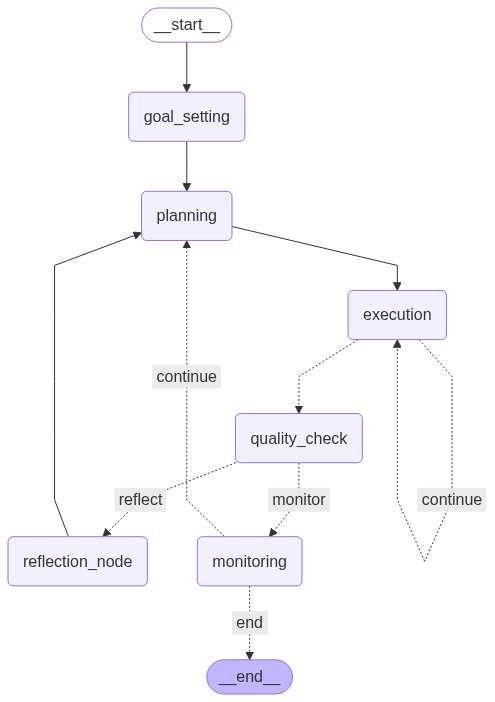

In [11]:
create_agentic_agent()

In [13]:
question = "2주전 은행채 발행액은?"
result = ask_agentic_ai(question)

print(f"답변: {result['answer']}")
print(f"신뢰도: {result['confidence']}")
print(f"목표: {result['goal']}")
print(f"계획: {result['plan']}")
print(f"실행 로그: {len(result['execution_log'])}개 단계")

답변: 
신뢰도: 0.7
목표: - 주요 목표: 사용자의 질문에 대한 정확한 답변을 제공하기 위해, 2주 전의 은행채 발행액에 관한 정보를 찾아내는 것입니다.

- 성공 기준: 제공된 답변은 최신 정보이며 정확해야 하며, 사용자가 원하는 정보를 충분히 포함하고 있어야 합니다. 또한, 답변이 간결하면서도 이해하기 쉬워야 합니다.

- 예상 복잡도: 4점

이유는 은행채 발행액을 확인하려면 금융 관련 데이터와 통계 자료를 검색해야 하기 때문입니다. 그러나 이러한 정보는 일반적으로 공식 웹사이트나 금융 뉴스 사이트에서 쉽게 찾을 수 있으므로 비교적 높은 점수를 부여했습니다. 다만, 최근 변동사항이나 특별한 이슈가 있을 경우 추가적인 설명이 필요할 수 있어 일부 복잡성이 존재합니다.
계획: ['date_extraction', 'question_routing', 'text_search', 'table_search', 'answer_generation', 'quality_check']
실행 로그: 8개 단계


In [ ]:
question = "2025년 1월 24일과 2025년 1월 17일의 국국"
result = ask_agentic_ai(question)

print(f"답변: {result['answer']}")
print(f"신뢰도: {result['confidence']}")
print(f"목표: {result['goal']}")
print(f"계획: {result['plan']}")
print(f"실행 로그: {len(result['execution_log'])}개 단계")

In [15]:
import os
import re
import json
import jsonlines
from typing import Annotated, Optional, Literal, List, Dict, Any
from datetime import datetime, timedelta
import operator
from uuid import uuid4

from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_naver.embeddings import ClovaXEmbeddings
from langchain_milvus.vectorstores import Milvus
from langchain_naver.chat_models import ChatClovaX
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
    AttributeInfo,
    StructuredQueryOutputParser,
    get_query_constructor_prompt
)
from langchain.retrievers.self_query.milvus import MilvusTranslator

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, field_validator
from langchain_core.runnables import RunnableConfig
import warnings
import logging

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from dotenv import load_dotenv
load_dotenv()

# ---------- Agentic AI State 정의 ----------
class AgenticState(TypedDict):
    # 사용자 입력
    question: str
    
    # Agentic AI 핵심 요소
    goal: str
    plan: List[str]
    current_step: int
    execution_log: List[Dict[str, Any]]
    reflection: Optional[str]
    confidence_score: float
    retry_count: int
    max_retries: int
    
    # 도구 및 검색 결과
    available_tools: List[str]
    selected_tools: List[str]
    
    # 기존 RAG 요소들
    routing_result: str
    routing_result_2: str
    expr: Optional[str]
    text_context: List[Document]
    table_context: List[Document]
    raptor_context: List[Document]
    image_context: List[Document]
    text_answer: str
    table_answer: str
    final_answer: str
    
    # 메시지 및 메타데이터
    messages: Annotated[List, add_messages]
    session_id: str
    timestamp: datetime

# ---------- 기존 모델 클래스들 유지 ----------
class TimeFilter(BaseModel):
    start_date: Optional[datetime] = None
    end_date: Optional[datetime] = None

class SearchQuery(BaseModel):
    query: str
    time_filter: TimeFilter

class Label(BaseModel):
    chunk_id: int = Field(description="The unique identifier of the text chunk")
    chain_of_thought: str = Field(description="The reasoning process used to evaluate the relevance")
    relevancy: int = Field(description="Relevancy score from 0 to 10, where 10 is most relevant", ge=0, le=10)

class RerankedResults(BaseModel):
    labels: list[Label] = Field(description="List of labeled and ranked chunks")

    @field_validator("labels")
    @classmethod
    def model_validate(cls, v: list[Label]) -> list[Label]:
        return sorted(v, key=lambda x: x.relevancy, reverse=True)

# ---------- 초기화 ----------
embeddings = ClovaXEmbeddings(model='bge-m3')
llm = ChatClovaX(model='HCX-005', temperature=0)
planning_llm = ChatClovaX(model='HCX-005', temperature=0.3)

URI = 'http://127.0.0.1:19530'

# 데이터베이스 초기화
text_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='text_db'
)

table_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='table_db'
)

raptor_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='raptor_db'
)

image_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='image_db'
)

# BM25 리트리버 초기화
filepath_text = './chunked_jsonl/text_semantic_per_80.jsonl'
filepath_table = './chunked_jsonl/table_v7.jsonl'

def load_documents(filepath):
    docs = []
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('\n('):
                    continue
                data = json.loads(line)
                doc = Document(
                    page_content=data['page_content'],
                    metadata=data['metadata']
                )
                docs.append(doc)
    except Exception as e:
        logger.error(f"문서 로딩 오류: {e}")
        return []
    return docs

splitted_doc_text = load_documents(filepath_text)
splitted_doc_table = load_documents(filepath_table)

# BM25 리트리버 초기화 (안전하게)
try:
    if splitted_doc_text:
        bm25_retriever_text = KiwiBM25Retriever.from_documents(splitted_doc_text)
        bm25_retriever_text.k = 50
    else:
        bm25_retriever_text = None
        
    if splitted_doc_table:
        bm25_retriever_table = KiwiBM25Retriever.from_documents(splitted_doc_table)
        bm25_retriever_table.k = 20
    else:
        bm25_retriever_table = None
except Exception as e:
    logger.error(f"BM25 리트리버 초기화 오류: {e}")
    bm25_retriever_text = None
    bm25_retriever_table = None

# ---------- 유틸리티 함수들 ----------
def safe_invoke_llm(messages, default_response="답변을 생성할 수 없습니다."):
    """LLM 호출을 안전하게 처리하는 함수"""
    try:
        response = llm.invoke(messages)
        return response.content if hasattr(response, 'content') else str(response)
    except Exception as e:
        logger.error(f"LLM 호출 실패: {e}")
        return default_response

def adjust_time_filter_to_week(time_filter):
    start_date = time_filter.start_date
    end_date = time_filter.end_date

    if start_date is None or end_date is None:
        if start_date is not None and end_date is None:
            start_of_week = start_date - timedelta(days=start_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        elif end_date is not None and start_date is None:
            start_of_week = end_date - timedelta(days=end_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        else:
            return None

    if start_date.year == end_date.year and start_date.month == end_date.month and start_date.day == end_date.day:
        start_of_week = start_date - timedelta(days=start_date.weekday())
        end_of_week = start_of_week + timedelta(days=6)
        return {
            "start_date": start_of_week.replace(hour=0, minute=0, second=0),
            "end_date": end_of_week.replace(hour=23, minute=59, second=59)
        }

    return {"start_date": start_date, "end_date": end_date}

def parse_search_query_response(response: str, question: str) -> SearchQuery:
    try:
        if hasattr(response, 'content'):
            content = response.content
        else:
            content = str(response)
        data = json.loads(content)
        if data.get("time_filter") is None:
            data["time_filter"] = {}
        if "query" not in data:
            data["query"] = question
        return SearchQuery(**data)
    except Exception as e:
        logger.error(f"검색 쿼리 파싱 실패: {e}")
        return SearchQuery(query=question, time_filter=TimeFilter())

def format_docs(docs):
    if not docs:
        return "관련 문서를 찾을 수 없습니다."
    return "\n\n".join(
        f"Issue Date: {doc.metadata.get('issue_date', 'Unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )

# ---------- Agentic AI 노드들 ----------

def goal_setting_node(state: AgenticState) -> AgenticState:
    """목표 설정 및 초기화 노드"""
    question = state["question"]
    
    goal_prompt = f"""
    사용자의 질문을 분석하여 명확한 목표를 설정하세요.
    질문: {question}
    
    다음 형식으로 목표를 설정하세요:
    - 주요 목표: [구체적인 목표]
    - 성공 기준: [답변의 품질 기준]
    - 예상 복잡도: [1-5 점수]
    """
    
    messages = [{"role": "user", "content": goal_prompt}]
    goal_response = safe_invoke_llm(messages, f"질문 '{question}'에 대한 정확하고 상세한 답변 제공")
    
    available_tools = [
        "date_extraction",
        "question_routing", 
        "text_search",
        "table_search",
        "raptor_search",
        "answer_generation"
    ]
    
    return {
        "goal": goal_response,
        "available_tools": available_tools,
        "current_step": 0,
        "execution_log": [{
            "action": "goal_setting", 
            "result": "목표 설정 완료", 
            "timestamp": datetime.now()
        }],
        "confidence_score": 0.0,
        "retry_count": 0,
        "max_retries": 2,  # 최대 재시도 횟수 줄임
        "session_id": str(uuid4()),
        "timestamp": datetime.now()
    }

def planning_node(state: AgenticState) -> AgenticState:
    """동적 계획 수립 노드"""
    question = state["question"]
    goal = state["goal"]
    retry_count = state.get("retry_count", 0)
    
    # 기본 계획으로 단순화
    plan = [
        "date_extraction", 
        "question_routing", 
        "text_search", 
        "table_search", 
        "answer_generation", 
        "quality_check"
    ]
    
    execution_log = state.get("execution_log", [])
    execution_log.append({
        "action": "planning", 
        "result": "계획 수립 완료", 
        "details": {"plan": plan},
        "timestamp": datetime.now()
    })
    
    return {
        "plan": plan,
        "current_step": 0,
        "execution_log": execution_log
    }

def execution_node(state: AgenticState) -> AgenticState:
    """실행 노드 - 현재 계획 단계 실행"""
    plan = state["plan"]
    current_step = state["current_step"]
    execution_log = state.get("execution_log", [])
    
    # 안전장치: 실행 로그가 너무 많으면 중단
    if len(execution_log) > 15:
        logger.warning("실행 로그 한계 도달, 실행 중단")
        return {
            "execution_log": execution_log + [{
                "action": "execution", 
                "result": "실행 로그 한계로 인한 강제 중단", 
                "timestamp": datetime.now()
            }],
            "current_step": len(plan)  # 모든 단계 완료로 설정
        }
    
    if current_step >= len(plan):
        execution_log.append({
            "action": "execution", 
            "result": "모든 단계 완료", 
            "timestamp": datetime.now()
        })
        return {"execution_log": execution_log}
    
    step = plan[current_step]
    log_entry = {"action": step, "timestamp": datetime.now()}
    
    try:
        if step == "date_extraction":
            result = extract_date_node(state)
            state.update(result)
            log_entry["result"] = "날짜 추출 완료"
            log_entry["details"] = {"expr": result.get("expr")}
            
        elif step == "question_routing":
            result = routing_node(state)
            state.update(result)
            log_entry["result"] = "질문 라우팅 완료"
            log_entry["details"] = {"routing": result.get("routing_result")}
            
        elif step == "secondary_routing":
            result = routing_2_node(state)
            state.update(result)
            log_entry["result"] = "세부 라우팅 완료"
            log_entry["details"] = {"routing_2": result.get("routing_result_2")}
            
        elif step == "text_search":
            result = text_retrieval_node(state)
            state.update(result)
            log_entry["result"] = "텍스트 검색 완료"
            log_entry["details"] = {"context_count": len(result.get("text_context", []))}
            
        elif step == "table_search":
            result = table_retrieval_node(state)
            state.update(result)
            log_entry["result"] = "테이블 검색 완료"
            log_entry["details"] = {"context_count": len(result.get("table_context", []))}
            
        elif step == "raptor_search":
            result = raptor_retrieval_node(state)
            state.update(result)
            log_entry["result"] = "RAPTOR 검색 완료"
            log_entry["details"] = {"context_count": len(result.get("raptor_context", []))}
            
        elif step == "answer_generation":
            # 단순화된 답변 생성 로직
            routing_result = state.get("routing_result", "").lower()
            
            # 모든 답변 생성 단계를 순차적으로 실행
            text_result = text_answer_node(state)
            state.update(text_result)
            
            table_result = table_answer_node(state)
            state.update(table_result)
            
            # 라우팅에 따른 최종 답변 생성
            if "요약" in routing_result:
                final_result = raptor_answer_node(state)
            else:
                final_result = general_answer_node(state)
            
            state.update(final_result)
            
            # 안전장치: final_answer가 없으면 기본값 설정
            if not state.get("final_answer") or not state.get("final_answer").strip():
                if state.get("text_answer") and state.get("text_answer").strip():
                    state["final_answer"] = state["text_answer"]
                elif state.get("table_answer") and state.get("table_answer").strip():
                    state["final_answer"] = state["table_answer"]
                else:
                    state["final_answer"] = "죄송합니다. 답변을 생성하는 중 문제가 발생했습니다."
            
            log_entry["result"] = "답변 생성 완료"
            log_entry["details"] = {"answer_length": len(state.get("final_answer", ""))}
            
        elif step == "quality_check":
            result = quality_check_node(state)
            state.update(result)
            log_entry["result"] = "품질 검증 완료"
            log_entry["details"] = {"confidence": result.get("confidence_score", 0)}
            
        else:
            log_entry["result"] = f"알 수 없는 단계: {step}"
            
    except Exception as e:
        logger.error(f"실행 단계 {step} 오류: {e}")
        log_entry["result"] = f"실행 오류: {str(e)}"
        log_entry["error"] = True
    
    execution_log.append(log_entry)
    
    return {
        "execution_log": execution_log,
        "current_step": current_step + 1
    }

def quality_check_node(state: AgenticState) -> AgenticState:
    """품질 검증 및 신뢰도 평가 노드"""
    final_answer = state.get("final_answer", "")
    question = state["question"]
    
    if not final_answer or not final_answer.strip():
        return {
            "confidence_score": 0.1,
            "reflection": "답변이 생성되지 않았습니다."
        }
    
    # 기본 품질 검증 (LLM 호출 없이)
    if len(final_answer) < 50:
        confidence_score = 0.4
    elif len(final_answer) < 200:
        confidence_score = 0.7
    else:
        confidence_score = 0.8
    
    # 품질이 낮으면 반성 필요
    if confidence_score < 0.6:
        reflection = f"품질 점수가 낮음 ({confidence_score}). 개선 필요."
    else:
        reflection = None
    
    return {
        "confidence_score": confidence_score,
        "reflection": reflection
    }

def reflection_node(state: AgenticState) -> AgenticState:
    """반성 및 재계획 노드"""
    reflection = state.get("reflection")
    retry_count = state.get("retry_count", 0)
    max_retries = state.get("max_retries", 2)
    execution_log = state.get("execution_log", [])
    
    if not reflection or retry_count >= max_retries:
        return {"reflection": None}
    
    # 간단한 재계획 (LLM 호출 없이)
    new_plan = [
        "date_extraction", "question_routing", "secondary_routing",
        "text_search", "table_search", "raptor_search", 
        "answer_generation", "quality_check"
    ]
    
    execution_log.append({
        "action": "reflection", 
        "result": "재계획 완료", 
        "timestamp": datetime.now()
    })
    
    return {
        "plan": new_plan,
        "current_step": 0,
        "retry_count": retry_count + 1,
        "reflection": None,
        "execution_log": execution_log
    }

def monitoring_node(state: AgenticState) -> AgenticState:
    """모니터링 및 로깅 노드"""
    execution_log = state.get("execution_log", [])
    confidence_score = state.get("confidence_score", 0)
    
    total_steps = len(execution_log)
    error_count = sum(1 for log in execution_log if log.get("error", False))
    success_rate = (total_steps - error_count) / total_steps if total_steps > 0 else 0
    
    monitoring_data = {
        "total_steps": total_steps,
        "error_count": error_count,
        "success_rate": success_rate,
        "confidence_score": confidence_score,
        "timestamp": datetime.now()
    }
    
    execution_log.append({
        "action": "monitoring",
        "result": "모니터링 완료",
        "details": monitoring_data,
        "timestamp": datetime.now()
    })
    
    return {"execution_log": execution_log}

# ---------- 기존 RAG 노드들 (에러 처리 강화) ----------

def extract_date_node(state: AgenticState) -> AgenticState:
    """날짜 추출 노드"""
    try:
        question = state["question"]
        today = datetime(2025, 1, 25)
        days_since_last_friday = (today.weekday() - 4) % 7
        last_friday = today - timedelta(days=days_since_last_friday)
        issue_date = last_friday.strftime("%Y-%m-%d")

        system_prompt = f"""
        You are an AI assistant that extracts date ranges from financial queries.
        The current report date is {issue_date}.
        Your task is to extract the relevant date or date range from the user's query
        and format it in YYYY-MM-DD format.
        If no date is specified, answer with None value.
        Return your answer as a JSON object in this format:
        {{
            "query": "<원본 질문>",
            "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} or {{"start_date": null, "end_date": null}}
        }}
        답변은 반드시 위 JSON 형태로만 해.
        """

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question},
        ]
        
        response = llm.invoke(messages)
        search_query = parse_search_query_response(response, question)
        parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

        if parsed_dates:
            start = parsed_dates['start_date']
            end = parsed_dates['end_date']
            expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
        else:
            expr = None

        return {"expr": expr}
    except Exception as e:
        logger.error(f"날짜 추출 오류: {e}")
        return {"expr": None}

def routing_node(state: AgenticState) -> AgenticState:
    """라우팅 노드 - 요약/예측/일반 분류"""
    try:
        question = state["question"]
        
        prompt = f'''주어진 사용자 질문을 `요약`, `예측`, 또는 `일반` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
        
        messages = [{"role": "user", "content": prompt}]
        response = safe_invoke_llm(messages, "일반")
        
        return {"routing_result": response.strip()}
    except Exception as e:
        logger.error(f"라우팅 오류: {e}")
        return {"routing_result": "일반"}

def routing_2_node(state: AgenticState) -> AgenticState:
    """라우팅 노드 2 - 날짜/호수 분류"""
    try:
        question = state["question"]
        
        prompt = f'''주어진 사용자 질문을 `날짜`, `호수` 중 하나로 분류하세요. 한 단어 이상으로 응답하지 마세요.
        
        <question>
        {question}
        </question>
        
        Classification:'''
        
        messages = [{"role": "user", "content": prompt}]
        response = safe_invoke_llm(messages, "날짜")
        
        return {"routing_result_2": response.strip()}
    except Exception as e:
        logger.error(f"세부 라우팅 오류: {e}")
        return {"routing_result_2": "날짜"}

def text_retrieval_node(state: AgenticState) -> AgenticState:
    """텍스트 검색 노드"""
    try:
        question = state["question"]
        expr = state.get("expr")
        
        if expr:
            context_raw = text_db.as_retriever(
                search_kwargs={'expr': expr, 'k': 25}
            ).invoke(question)
        else:
            context_raw = text_db.as_retriever(search_kwargs={'k': 25}).invoke(question)
        
        return {"text_context": context_raw}
    except Exception as e:
        logger.error(f"텍스트 검색 오류: {e}")
        return {"text_context": []}

def table_retrieval_node(state: AgenticState) -> AgenticState:
    """테이블 검색 노드"""
    try:
        question = state["question"]
        expr = state.get("expr")
        
        # Milvus 검색
        if expr:
            milvus_results = table_db.as_retriever(
                search_kwargs={'expr': expr, 'k': 10}
            ).invoke(question)
        else:
            milvus_results = table_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
        
        # BM25 검색 (안전하게 처리)
        bm25_filtered = []
        if bm25_retriever_table:
            try:
                bm25_raw = bm25_retriever_table.invoke(question)
                
                if expr:
                    start_date = expr.split("'")[1]
                    end_date = expr.split("'")[3]
                    bm25_filtered = [
                        doc for doc in bm25_raw
                        if start_date <= doc.metadata.get("issue_date", "") <= end_date
                    ]
                else:
                    bm25_filtered = bm25_raw
            except Exception as e:
                logger.error(f"BM25 검색 오류: {e}")
        
        combined_context = milvus_results + bm25_filtered
        
        return {"table_context": combined_context}
    except Exception as e:
        logger.error(f"테이블 검색 오류: {e}")
        return {"table_context": []}

def raptor_retrieval_node(state: AgenticState) -> AgenticState:
    """RAPTOR 검색 노드"""
    try:
        question = state["question"]
        expr = state.get("expr")
        routing_result_2 = state.get("routing_result_2", "")
        
        if '날짜' in routing_result_2.lower() and expr:
            context = raptor_db.as_retriever(
                search_kwargs={'expr': expr, 'k': 10}
            ).invoke(question)
        else:
            try:
                metadata_field_info = [
                    AttributeInfo(
                        name='source',
                        description='문서의 번호. 네 자리의 숫자와 "호"로 이루어져 있다. 현재 1090호부터 1120호까지 존재한다.',
                        type='string',
                    ),
                ]
                
                prompt_query = get_query_constructor_prompt(
                    'summary of weekly financial report about bonds',
                    metadata_field_info
                )
                
                output_parser = StructuredQueryOutputParser.from_components()
                query_constructor = prompt_query | llm | output_parser
                
                retriever_raptor = SelfQueryRetriever(
                    query_constructor=query_constructor,
                    vectorstore=raptor_db,
                    structured_query_translator=MilvusTranslator(),
                    search_kwargs={'k': 10}
                )
                
                context = retriever_raptor.invoke(question)
            except Exception as e:
                logger.error(f"Self-query retriever 오류: {e}")
                context = raptor_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
        
        return {"raptor_context": context}
    except Exception as e:
        logger.error(f"RAPTOR 검색 오류: {e}")
        return {"raptor_context": []}

def text_answer_node(state: AgenticState) -> AgenticState:
    """텍스트 답변 생성 노드"""
    try:
        question = state["question"]
        context = state.get("text_context", [])
        
        text_prompt = f'''today is '2025-01-25'. You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        If question has date expressions, context already filtered with the date expression, so ignore about the date and answer without it.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {format_docs(context)}

        #Answer:'''
        
        messages = [{"role": "user", "content": text_prompt}]
        response = safe_invoke_llm(messages, "텍스트 검색 결과로 답변을 생성할 수 없습니다.")
        
        return {"text_answer": response}
    except Exception as e:
        logger.error(f"텍스트 답변 생성 오류: {e}")
        return {"text_answer": "텍스트 답변 생성 중 오류가 발생했습니다."}

def table_answer_node(state: AgenticState) -> AgenticState:
    """테이블 답변 생성 노드"""
    try:
        question = state["question"]
        context = state.get("table_context", [])
        
        table_prompt = f'''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved table to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.

        #Question:
        {question}
        #Context:
        {format_docs(context)}

        #Answer:'''
        
        messages = [{"role": "user", "content": table_prompt}]
        response = safe_invoke_llm(messages, "테이블 검색 결과로 답변을 생성할 수 없습니다.")
        
        return {"table_answer": response}
    except Exception as e:
        logger.error(f"테이블 답변 생성 오류: {e}")
        return {"table_answer": "테이블 답변 생성 중 오류가 발생했습니다."}

def raptor_answer_node(state: AgenticState) -> AgenticState:
    """RAPTOR 답변 생성 노드"""
    try:
        question = state["question"]
        context = state.get("raptor_context", [])
        
        raptor_prompt = f'''You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        Answer in Korean. Answer in detail.
        If the context mentions an unrelated date, do not mention that part.
        Summarize and organize your answers based on the various issues that apply to the period.

        #Question:
        {question}
        #Context:
        {format_docs(context)}

        #Answer:'''
        
        messages = [{"role": "user", "content": raptor_prompt}]
        response = safe_invoke_llm(messages, "RAPTOR 검색 결과로 답변을 생성할 수 없습니다.")
        
        return {"final_answer": response}
    except Exception as e:
        logger.error(f"RAPTOR 답변 생성 오류: {e}")
        return {"final_answer": "RAPTOR 답변 생성 중 오류가 발생했습니다."}

def general_answer_node(state: AgenticState) -> AgenticState:
    """일반 답변 생성 노드"""
    try:
        question = state["question"]
        text_answer = state.get("text_answer", "")
        table_answer = state.get("table_answer", "")
        
        # 유효한 답변이 있는지 확인
        valid_text = text_answer and "답변을 생성할 수 없습니다" not in text_answer and "오류가 발생했습니다" not in text_answer
        valid_table = table_answer and "답변을 생성할 수 없습니다" not in table_answer and "오류가 발생했습니다" not in table_answer
        
        if not valid_text and not valid_table:
            return {"final_answer": "죄송합니다. 관련 정보를 찾을 수 없어 답변을 생성할 수 없습니다."}
        
        general_prompt = f'''You are question-answering AI chatbot about financial reports.
        주어진 두 개의 정보는 table과 text에서 가져온 정보들이야. 이 정보를 바탕으로 질문에 대해 자세히 설명해줘.
        
        If one of the table or text says it doesn't know or it can't answer, don't mention with that.
        And some questions may not be answered simply with context, but rather require inference. In those cases, answer by inference. 
        
        #Question:
        {question}

        #Text Answer:
        {text_answer if valid_text else "텍스트 정보 없음"}

        #Table Answer:
        {table_answer if valid_table else "테이블 정보 없음"}
        '''
        
        messages = [{"role": "user", "content": general_prompt}]
        response = safe_invoke_llm(messages, "종합 답변을 생성할 수 없습니다.")
        
        return {"final_answer": response}
    except Exception as e:
        logger.error(f"일반 답변 생성 오류: {e}")
        return {"final_answer": "답변 생성 중 오류가 발생했습니다."}

# ---------- Agentic AI 그래프 구축 ----------

def create_agentic_agent():
    """완전한 Agentic AI 에이전트 생성"""
    
    workflow = StateGraph(AgenticState)
    
    # Agentic AI 노드들 추가
    workflow.add_node("goal_setting", goal_setting_node)
    workflow.add_node("planning", planning_node)
    workflow.add_node("execution", execution_node)
    workflow.add_node("quality_check", quality_check_node)
    workflow.add_node("reflection_node", reflection_node)
    workflow.add_node("monitoring", monitoring_node)
    
    # 조건부 엣지 함수들 (개선된 버전)
    def should_continue_execution(state: AgenticState) -> str:
        """실행을 계속할지 결정"""
        current_step = state.get("current_step", 0)
        plan = state.get("plan", [])
        execution_log = state.get("execution_log", [])
        
        # 안전장치: 최대 단계 수 제한
        if current_step >= 10 or len(execution_log) > 15:
            logger.warning("최대 실행 단계에 도달했습니다.")
            return "quality_check"
        
        if current_step < len(plan):
            return "continue"
        else:
            return "quality_check"
    
    def should_reflect(state: AgenticState) -> str:
        """반성이 필요한지 결정"""
        reflection = state.get("reflection")
        retry_count = state.get("retry_count", 0)
        max_retries = state.get("max_retries", 2)
        
        # 더 엄격한 조건
        if reflection and retry_count < max_retries and retry_count < 1:  # 최대 1회 재시도로 제한
            return "reflect"
        else:
            return "monitor"
    
    def should_end(state: AgenticState) -> str:
        """종료할지 결정"""
        confidence_score = state.get("confidence_score", 0)
        retry_count = state.get("retry_count", 0)
        max_retries = state.get("max_retries", 2)
        execution_log = state.get("execution_log", [])
        
        # 강제 종료 조건 추가
        if len(execution_log) > 12:  # 실행 로그가 12개를 초과하면 강제 종료
            logger.warning("실행 로그 한계에 도달하여 강제 종료합니다.")
            return "end"
        
        if confidence_score >= 0.6 or retry_count >= max_retries:
            return "end"
        else:
            return "continue"
    
    # 워크플로우 구성
    workflow.add_edge(START, "goal_setting")
    workflow.add_edge("goal_setting", "planning")
    workflow.add_edge("planning", "execution")
    
    # 실행 루프
    workflow.add_conditional_edges(
        "execution",
        should_continue_execution,
        {
            "continue": "execution",
            "quality_check": "quality_check"
        }
    )
    
    # 품질 검증 후 반성 여부 결정
    workflow.add_conditional_edges(
        "quality_check",
        should_reflect,
        {
            "reflect": "reflection_node",
            "monitor": "monitoring"
        }
    )
    
    # 반성 후 재계획
    workflow.add_edge("reflection_node", "planning")
    
    # 모니터링 후 종료 여부 결정
    workflow.add_conditional_edges(
        "monitoring",
        should_end,
        {
            "end": END,
            "continue": "planning"
        }
    )
    
    return workflow.compile()

# ---------- 사용 인터페이스 ----------

def ask_agentic_ai(question: str, session_id: Optional[str] = None):
    """Agentic AI 기반 질문 응답 함수 (재귀 한계 해결)"""
    try:
        agent = create_agentic_agent()
        
        # 초기 상태 설정
        initial_state = {
            "question": question,
            "goal": "",
            "plan": [],
            "current_step": 0,
            "execution_log": [],
            "reflection": None,
            "confidence_score": 0.0,
            "retry_count": 0,
            "max_retries": 2,  # 재시도 횟수 줄임
            "available_tools": [],
            "selected_tools": [],
            "routing_result": "",
            "routing_result_2": "",
            "expr": None,
            "text_context": [],
            "table_context": [],
            "raptor_context": [],
            "image_context": [],
            "text_answer": "",
            "table_answer": "",
            "final_answer": "",
            "messages": [],
            "session_id": session_id or str(uuid4()),
            "timestamp": datetime.now()
        }
        
        # 재귀 한계를 늘린 설정으로 실행
        config = RunnableConfig(recursion_limit=30)
        result = agent.invoke(initial_state, config)
        
        # 최종 답변 안전장치
        final_answer = result.get("final_answer", "").strip()
        if not final_answer:
            final_answer = "죄송합니다. 답변을 생성하는 중 문제가 발생했습니다."
        
        # 디버깅 정보 출력
        logger.info(f"Final answer in state: '{final_answer}'")
        logger.info(f"Text answer: '{result.get('text_answer', 'NOT SET')}'")
        logger.info(f"Table answer: '{result.get('table_answer', 'NOT SET')}'")
        logger.info(f"Routing result: '{result.get('routing_result', 'NOT SET')}'")
        
        return {
            "answer": final_answer,
            "confidence": result.get("confidence_score", 0),
            "execution_log": result.get("execution_log", []),
            "session_id": result.get("session_id"),
            "goal": result.get("goal", ""),
            "plan": result.get("plan", [])
        }
        
    except Exception as e:
        logger.error(f"Agentic AI 실행 오류: {e}")
        return {
            "answer": f"시스템 오류가 발생했습니다: {str(e)}",
            "confidence": 0.0,
            "execution_log": [{"action": "error", "result": str(e), "timestamp": datetime.now()}],
            "session_id": session_id or str(uuid4()),
            "goal": "오류 발생",
            "plan": []
        }

# 스트림 방식 사용 (대안)
def ask_agentic_ai_stream(question: str, session_id: Optional[str] = None):
    """스트림 방식으로 실행하여 더 세밀한 제어"""
    try:
        agent = create_agentic_agent()
        initial_state = {
            "question": question,
            "goal": "",
            "plan": [],
            "current_step": 0,
            "execution_log": [],
            "reflection": None,
            "confidence_score": 0.0,
            "retry_count": 0,
            "max_retries": 2,
            "available_tools": [],
            "selected_tools": [],
            "routing_result": "",
            "routing_result_2": "",
            "expr": None,
            "text_context": [],
            "table_context": [],
            "raptor_context": [],
            "image_context": [],
            "text_answer": "",
            "table_answer": "",
            "final_answer": "",
            "messages": [],
            "session_id": session_id or str(uuid4()),
            "timestamp": datetime.now()
        }
        
        config = {"recursion_limit": 30}
        result = None
        
        for output in agent.stream(initial_state, config):
            for key, value in output.items():
                logger.info(f"Node '{key}' completed")
                result = value
                
        return {
            "answer": result.get("final_answer", "답변을 생성할 수 없습니다."),
            "confidence": result.get("confidence_score", 0),
            "execution_log": result.get("execution_log", []),
            "session_id": result.get("session_id"),
            "goal": result.get("goal", ""),
            "plan": result.get("plan", [])
        }
        
    except Exception as e:
        logger.error(f"스트림 실행 오류: {e}")
        return {
            "answer": "시스템 오류로 인해 답변을 생성할 수 없습니다.",
            "confidence": 0.0,
            "execution_log": [],
            "session_id": session_id or str(uuid4()),
            "goal": "오류 발생",
            "plan": []
        }

# 메인 실행 함수
if __name__ == "__main__":
    # 예시 실행
    question = "연준의 비공식 대변인은?"
    result = ask_agentic_ai(question)
    
    print(f"답변: {result['answer']}")
    print(f"신뢰도: {result['confidence']}")
    print(f"목표: {result['goal']}")
    print(f"계획: {result['plan']}")
    print(f"실행 로그: {len(result['execution_log'])}개 단계")
    
    # 실행 로그 상세 출력
    for log in result['execution_log']:
        print(f"Action: {log['action']}")
        print(f"Result: {log['result']}")
        if 'details' in log:
            print(f"Details: {log['details']}")
        print("---")


INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200

답변: 죄송합니다. 답변을 생성하는 중 문제가 발생했습니다.
신뢰도: 0.1
목표: 주요 목표: 연방준비제도(연준)의 비공식 대변인에 대한 정보를 제공

성공 기준: 
- 답변은 질문에 직접적으로 대답해야 합니다.
- 대변인의 이름과 그들이 어떤 역할을 수행하는지에 대한 간략한 설명이 포함되어야 합니다.
- 가능하다면, 대변인이 언론에 어떻게 접근하는지 또는 과거 발언 중 중요한 부분을 요약합니다.

예상 복잡도: 3점

이유: 이 질문은 특정 기관의 비공식 대변인에 관한 것으로, 이에 대한 정보는 일반적으로 공개되어 있지만, 최신 정보나 상황에 따라 변할 수 있습니다. 따라서 기본적인 조사와 확인 작업이 필요하며, 이는 중간 정도의 복잡성을 가집니다. 그러나 이 주제는 매우 전문적이거나 기술적인 내용을 요구하지 않으므로 더 높은 점수를 부여하지는 않습니다.
계획: ['date_extraction', 'question_routing', 'text_search', 'table_search', 'answer_generation', 'quality_check']
실행 로그: 17개 단계
Action: goal_setting
Result: 목표 설정 완료
---
Action: planning
Result: 계획 수립 완료
Details: {'plan': ['date_extraction', 'question_routing', 'text_search', 'table_search', 'answer_generation', 'quality_check']}
---
Action: date_extraction
Result: 날짜 추출 완료
Details: {'expr': None}
---
Action: question_routing
Result: 질문 라우팅 완료
Details: {'routing': '일반'}
---
Action: text_search
Result: 텍스트 검색 완료
Details: {'context_count': 25}
---
Action: table_searc

In [18]:
import os
import re
import json
import jsonlines
from typing import Annotated, Optional, Literal, List, Dict, Any
from datetime import datetime, timedelta
import operator
from uuid import uuid4

from langchain.schema import Document
from langchain_experimental.text_splitter import SemanticChunker
from langchain_naver.embeddings import ClovaXEmbeddings
from langchain_milvus.vectorstores import Milvus
from langchain_naver.chat_models import ChatClovaX
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import (
    AttributeInfo,
    StructuredQueryOutputParser,
    get_query_constructor_prompt
)
from langchain.retrievers.self_query.milvus import MilvusTranslator

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import GraphRecursionError
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, field_validator
from langchain_core.runnables import RunnableConfig
import warnings
import logging

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from dotenv import load_dotenv
load_dotenv()

# ---------- 개선된 Agentic AI State 정의 ----------
class AgenticState(TypedDict):
    # 사용자 입력
    question: str
    
    # Agentic AI 핵심 요소
    goal: str
    plan: List[str]
    current_step: int
    execution_log: List[Dict[str, Any]]
    confidence_score: float
    
    # 도구 및 검색 결과
    available_tools: List[str]
    
    # 기존 RAG 요소들
    routing_result: str
    routing_result_2: str
    expr: Optional[str]
    text_context: List[Document]
    table_context: List[Document]
    raptor_context: List[Document]
    text_answer: str
    table_answer: str
    final_answer: str
    
    # 메시지 및 메타데이터
    messages: Annotated[List, add_messages]
    session_id: str
    timestamp: datetime
    
    # 마지막 유효 답변 저장용 (핵심 추가)
    last_valid_answer: str
    answer_history: List[str]

# ---------- 기존 모델 클래스들 유지 ----------
class TimeFilter(BaseModel):
    start_date: Optional[datetime] = None
    end_date: Optional[datetime] = None

class SearchQuery(BaseModel):
    query: str
    time_filter: TimeFilter

class Label(BaseModel):
    chunk_id: int = Field(description="The unique identifier of the text chunk")
    chain_of_thought: str = Field(description="The reasoning process used to evaluate the relevance")
    relevancy: int = Field(description="Relevancy score from 0 to 10, where 10 is most relevant", ge=0, le=10)

class RerankedResults(BaseModel):
    labels: list[Label] = Field(description="List of labeled and ranked chunks")

    @field_validator("labels")
    @classmethod
    def model_validate(cls, v: list[Label]) -> list[Label]:
        return sorted(v, key=lambda x: x.relevancy, reverse=True)

# ---------- 초기화 ----------
embeddings = ClovaXEmbeddings(model='bge-m3')
llm = ChatClovaX(model='HCX-005', temperature=0)
planning_llm = ChatClovaX(model='HCX-005', temperature=0.3)

URI = 'http://127.0.0.1:19530'

# 데이터베이스 초기화
text_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='text_db'
)

table_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='table_db'
)

raptor_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='raptor_db'
)

image_db = Milvus(
    embedding_function=embeddings,
    connection_args={'uri': URI},
    index_params={'index_type': 'AUTOINDEX', 'metric_type': 'IP'},
    collection_name='image_db'
)

# BM25 리트리버 초기화
filepath_text = './chunked_jsonl/text_semantic_per_80.jsonl'
filepath_table = './chunked_jsonl/table_v7.jsonl'

def load_documents(filepath):
    docs = []
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('\n('):
                    continue
                data = json.loads(line)
                doc = Document(
                    page_content=data['page_content'],
                    metadata=data['metadata']
                )
                docs.append(doc)
    except Exception as e:
        logger.error(f"문서 로딩 오류: {e}")
        return []
    return docs

splitted_doc_text = load_documents(filepath_text)
splitted_doc_table = load_documents(filepath_table)

# BM25 리트리버 초기화 (안전하게)
try:
    if splitted_doc_text:
        bm25_retriever_text = KiwiBM25Retriever.from_documents(splitted_doc_text)
        bm25_retriever_text.k = 50
    else:
        bm25_retriever_text = None
        
    if splitted_doc_table:
        bm25_retriever_table = KiwiBM25Retriever.from_documents(splitted_doc_table)
        bm25_retriever_table.k = 20
    else:
        bm25_retriever_table = None
except Exception as e:
    logger.error(f"BM25 리트리버 초기화 오류: {e}")
    bm25_retriever_text = None
    bm25_retriever_table = None

# ---------- 유틸리티 함수들 ----------
def safe_invoke_llm(messages, default_response="답변을 생성할 수 없습니다."):
    """LLM 호출을 안전하게 처리하는 함수"""
    try:
        response = llm.invoke(messages)
        return response.content if hasattr(response, 'content') else str(response)
    except Exception as e:
        logger.error(f"LLM 호출 실패: {e}")
        return default_response

def save_valid_answer(state: AgenticState, answer: str) -> None:
    """유효한 답변을 저장하는 함수"""
    if answer and answer.strip() and len(answer.strip()) > 10:
        # 오류 메시지가 아닌 경우에만 저장
        error_phrases = ["답변을 생성할 수 없습니다", "오류가 발생했습니다", "죄송합니다", "문제가 발생했습니다"]
        if not any(phrase in answer for phrase in error_phrases):
            state["last_valid_answer"] = answer.strip()
            if "answer_history" not in state:
                state["answer_history"] = []
            state["answer_history"].append(answer.strip())
            logger.info(f"유효한 답변 저장: {answer[:100]}...")

def get_best_available_answer(state: AgenticState) -> str:
    """사용 가능한 최고의 답변을 반환"""
    # 1. 마지막 유효 답변 확인
    if state.get("last_valid_answer"):
        return state["last_valid_answer"]
    
    # 2. 답변 히스토리에서 가장 긴 답변 선택
    if state.get("answer_history"):
        best_answer = max(state["answer_history"], key=len)
        if len(best_answer) > 50:
            return best_answer
    
    # 3. 현재 상태의 답변들 확인
    for answer_key in ["final_answer", "text_answer", "table_answer"]:
        answer = state.get(answer_key, "")
        if answer and len(answer.strip()) > 50:
            error_phrases = ["답변을 생성할 수 없습니다", "오류가 발생했습니다", "죄송합니다"]
            if not any(phrase in answer for phrase in error_phrases):
                return answer.strip()
    
    # 4. 기본 답변
    return "관련 정보를 찾을 수 없습니다."

def adjust_time_filter_to_week(time_filter):
    start_date = time_filter.start_date
    end_date = time_filter.end_date

    if start_date is None or end_date is None:
        if start_date is not None and end_date is None:
            start_of_week = start_date - timedelta(days=start_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        elif end_date is not None and start_date is None:
            start_of_week = end_date - timedelta(days=end_date.weekday())
            end_of_week = start_of_week + timedelta(days=6)
            return {
                "start_date": start_of_week.replace(hour=0, minute=0, second=0),
                "end_date": end_of_week.replace(hour=23, minute=59, second=59)
            }
        else:
            return None

    if start_date.year == end_date.year and start_date.month == end_date.month and start_date.day == end_date.day:
        start_of_week = start_date - timedelta(days=start_date.weekday())
        end_of_week = start_of_week + timedelta(days=6)
        return {
            "start_date": start_of_week.replace(hour=0, minute=0, second=0),
            "end_date": end_of_week.replace(hour=23, minute=59, second=59)
        }

    return {"start_date": start_date, "end_date": end_date}

def parse_search_query_response(response: str, question: str) -> SearchQuery:
    try:
        if hasattr(response, 'content'):
            content = response.content
        else:
            content = str(response)
        data = json.loads(content)
        if data.get("time_filter") is None:
            data["time_filter"] = {}
        if "query" not in data:
            data["query"] = question
        return SearchQuery(**data)
    except Exception as e:
        logger.error(f"검색 쿼리 파싱 실패: {e}")
        return SearchQuery(query=question, time_filter=TimeFilter())

def format_docs(docs):
    if not docs:
        return "관련 문서를 찾을 수 없습니다."
    return "\n\n".join(
        f"Issue Date: {doc.metadata.get('issue_date', 'Unknown')}\nContent: {doc.page_content}"
        for doc in docs
    )

# ---------- 단순화된 노드들 ----------

def initialize_node(state: AgenticState) -> AgenticState:
    """초기화 노드 - 목표 설정과 계획을 한 번에 처리"""
    question = state["question"]
    
    # 기본 목표 설정
    goal = f"질문 '{question}'에 대한 정확하고 상세한 답변 제공"
    
    # 단순화된 계획
    plan = ["search_and_answer"]  # 하나의 단계로 단순화
    
    return {
        "goal": goal,
        "plan": plan,
        "current_step": 0,
        "execution_log": [{
            "action": "initialize", 
            "result": "초기화 완료", 
            "timestamp": datetime.now()
        }],
        "confidence_score": 0.0,
        "available_tools": ["text_search", "table_search"],
        "session_id": str(uuid4()),
        "timestamp": datetime.now(),
        "last_valid_answer": "",
        "answer_history": []
    }

def search_and_answer_node(state: AgenticState) -> AgenticState:
    """검색과 답변 생성을 한 번에 처리하는 통합 노드"""
    question = state["question"]
    execution_log = state.get("execution_log", [])
    
    try:
        # 1. 날짜 추출
        expr = None
        try:
            today = datetime(2025, 1, 25)
            days_since_last_friday = (today.weekday() - 4) % 7
            last_friday = today - timedelta(days=days_since_last_friday)
            issue_date = last_friday.strftime("%Y-%m-%d")

            system_prompt = f"""
            You are an AI assistant that extracts date ranges from financial queries.
            The current report date is {issue_date}.
            Your task is to extract the relevant date or date range from the user's query
            and format it in YYYY-MM-DD format.
            If no date is specified, answer with None value.
            Return your answer as a JSON object in this format:
            {{
                "query": "<원본 질문>",
                "time_filter": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD"}} or {{"start_date": null, "end_date": null}}
            }}
            답변은 반드시 위 JSON 형태로만 해.
            """

            messages = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": question},
            ]
            
            response = llm.invoke(messages)
            search_query = parse_search_query_response(response, question)
            parsed_dates = adjust_time_filter_to_week(search_query.time_filter)

            if parsed_dates:
                start = parsed_dates['start_date']
                end = parsed_dates['end_date']
                expr = f"issue_date >= '{start.strftime('%Y%m%d')}' AND issue_date <= '{end.strftime('%Y%m%d')}'"
        except Exception as e:
            logger.error(f"날짜 추출 오류: {e}")
            expr = None

        # 2. 텍스트 검색
        text_context = []
        try:
            if expr:
                text_context = text_db.as_retriever(
                    search_kwargs={'expr': expr, 'k': 25}
                ).invoke(question)
            else:
                text_context = text_db.as_retriever(search_kwargs={'k': 25}).invoke(question)
        except Exception as e:
            logger.error(f"텍스트 검색 오류: {e}")

        # 3. 테이블 검색
        table_context = []
        try:
            if expr:
                milvus_results = table_db.as_retriever(
                    search_kwargs={'expr': expr, 'k': 10}
                ).invoke(question)
            else:
                milvus_results = table_db.as_retriever(search_kwargs={'k': 10}).invoke(question)
            
            bm25_filtered = []
            if bm25_retriever_table:
                try:
                    bm25_raw = bm25_retriever_table.invoke(question)
                    if expr:
                        start_date = expr.split("'")[1]
                        end_date = expr.split("'")[3]
                        bm25_filtered = [
                            doc for doc in bm25_raw
                            if start_date <= doc.metadata.get("issue_date", "") <= end_date
                        ]
                    else:
                        bm25_filtered = bm25_raw
                except Exception as e:
                    logger.error(f"BM25 검색 오류: {e}")
            
            table_context = milvus_results + bm25_filtered
        except Exception as e:
            logger.error(f"테이블 검색 오류: {e}")

        # 4. 텍스트 답변 생성
        text_answer = ""
        try:
            text_prompt = f'''today is '2025-01-25'. You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If you don't know the answer, just say that you don't know.
            Answer in Korean. Answer in detail.

            #Question:
            {question}
            #Context:
            {format_docs(text_context)}

            #Answer:'''
            
            messages = [{"role": "user", "content": text_prompt}]
            text_answer = safe_invoke_llm(messages, "")
            
            # 유효한 텍스트 답변이면 저장
            if text_answer and len(text_answer.strip()) > 50:
                save_valid_answer(state, text_answer)
                
        except Exception as e:
            logger.error(f"텍스트 답변 생성 오류: {e}")

        # 5. 테이블 답변 생성
        table_answer = ""
        try:
            table_prompt = f'''You are an assistant for question-answering tasks.
            Use the following pieces of retrieved table to answer the question.
            If you don't know the answer, just say that you don't know.
            Answer in Korean. Answer in detail.

            #Question:
            {question}
            #Context:
            {format_docs(table_context)}

            #Answer:'''
            
            messages = [{"role": "user", "content": table_prompt}]
            table_answer = safe_invoke_llm(messages, "")
            
            # 유효한 테이블 답변이면 저장
            if table_answer and len(table_answer.strip()) > 50:
                save_valid_answer(state, table_answer)
                
        except Exception as e:
            logger.error(f"테이블 답변 생성 오류: {e}")

        # 6. 최종 답변 생성
        final_answer = ""
        try:
            # 유효한 답변이 있는지 확인
            valid_text = text_answer and len(text_answer.strip()) > 50 and "답변을 생성할 수 없습니다" not in text_answer
            valid_table = table_answer and len(table_answer.strip()) > 50 and "답변을 생성할 수 없습니다" not in table_answer
            
            if valid_text or valid_table:
                general_prompt = f'''You are question-answering AI chatbot about financial reports.
                주어진 두 개의 정보는 table과 text에서 가져온 정보들이야. 이 정보를 바탕으로 질문에 대해 자세히 설명해줘.
                
                If one of the table or text says it doesn't know or it can't answer, don't mention with that.
                And some questions may not be answered simply with context, but rather require inference. In those cases, answer by inference. 
                
                #Question:
                {question}

                #Text Answer:
                {text_answer if valid_text else "텍스트 정보 없음"}

                #Table Answer:
                {table_answer if valid_table else "테이블 정보 없음"}
                '''
                
                messages = [{"role": "user", "content": general_prompt}]
                final_answer = safe_invoke_llm(messages, "")
                
                # 최종 답변 저장
                if final_answer and len(final_answer.strip()) > 50:
                    save_valid_answer(state, final_answer)
            
        except Exception as e:
            logger.error(f"최종 답변 생성 오류: {e}")

        # 7. 최고의 답변 선택
        best_answer = get_best_available_answer(state)
        
        execution_log.append({
            "action": "search_and_answer",
            "result": "검색 및 답변 생성 완료",
            "details": {
                "text_context_count": len(text_context),
                "table_context_count": len(table_context),
                "final_answer_length": len(best_answer)
            },
            "timestamp": datetime.now()
        })
        
        return {
            "expr": expr,
            "text_context": text_context,
            "table_context": table_context,
            "text_answer": text_answer,
            "table_answer": table_answer,
            "final_answer": best_answer,
            "execution_log": execution_log,
            "current_step": 1,
            "confidence_score": 0.8 if len(best_answer) > 100 else 0.6
        }
        
    except Exception as e:
        logger.error(f"검색 및 답변 생성 전체 오류: {e}")
        
        # 오류 발생 시에도 최고의 답변 반환
        best_answer = get_best_available_answer(state)
        
        execution_log.append({
            "action": "search_and_answer",
            "result": f"오류 발생하지만 답변 제공: {str(e)}",
            "timestamp": datetime.now()
        })
        
        return {
            "final_answer": best_answer,
            "execution_log": execution_log,
            "current_step": 1,
            "confidence_score": 0.5
        }

# ---------- 단순화된 그래프 구축 ----------

def create_simple_agent():
    """단순화된 에이전트 생성"""
    
    workflow = StateGraph(AgenticState)
    
    # 단순화된 노드들만 추가
    workflow.add_node("initialize", initialize_node)
    workflow.add_node("search_and_answer", search_and_answer_node)
    
    # 단순한 선형 워크플로우
    workflow.add_edge(START, "initialize")
    workflow.add_edge("initialize", "search_and_answer")
    workflow.add_edge("search_and_answer", END)
    
    return workflow.compile()

# ---------- 개선된 사용 인터페이스 ----------

def ask_agentic_ai(question: str, session_id: Optional[str] = None):
    """개선된 Agentic AI 기반 질문 응답 함수"""
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "goal": "",
        "plan": [],
        "current_step": 0,
        "execution_log": [],
        "confidence_score": 0.0,
        "available_tools": [],
        "routing_result": "",
        "routing_result_2": "",
        "expr": None,
        "text_context": [],
        "table_context": [],
        "raptor_context": [],
        "text_answer": "",
        "table_answer": "",
        "final_answer": "",
        "messages": [],
        "session_id": session_id or str(uuid4()),
        "timestamp": datetime.now(),
        "last_valid_answer": "",
        "answer_history": []
    }
    
    try:
        agent = create_simple_agent()
        
        # 재귀 한계를 낮게 설정 (검색 결과 참조)
        config = RunnableConfig(recursion_limit=10)
        
        result = None
        final_answer = ""
        
        try:
            # 스트림 방식으로 실행하여 중간 상태 추적
            for output in agent.stream(initial_state, config):
                for key, value in output.items():
                    logger.info(f"Node '{key}' completed")
                    result = value
                    
                    # 중간에 유효한 답변이 생성되면 저장
                    if value.get("final_answer") and len(value.get("final_answer", "").strip()) > 50:
                        final_answer = value["final_answer"]
                        logger.info(f"중간 답변 저장: {final_answer[:100]}...")
                        
        except GraphRecursionError as e:
            logger.warning(f"재귀 한계 도달: {e}")
            # 재귀 한계 도달 시 마지막 유효 답변 사용
            if result:
                final_answer = get_best_available_answer(result)
            
        except Exception as e:
            logger.error(f"그래프 실행 중 오류: {e}")
            # 기타 오류 발생 시에도 마지막 유효 답변 사용
            if result:
                final_answer = get_best_available_answer(result)
        
        # 최종 답변 결정
        if not final_answer and result:
            final_answer = get_best_available_answer(result)
        
        if not final_answer:
            final_answer = "관련 정보를 찾을 수 없습니다."
        
        # 결과 반환
        return {
            "answer": final_answer,
            "confidence": result.get("confidence_score", 0.7) if result else 0.7,
            "execution_log": result.get("execution_log", []) if result else [],
            "session_id": result.get("session_id") if result else (session_id or str(uuid4())),
            "goal": result.get("goal", "") if result else "",
            "plan": result.get("plan", []) if result else []
        }
        
    except Exception as e:
        logger.error(f"전체 시스템 오류: {e}")
        return {
            "answer": "관련 정보를 찾을 수 없습니다.",
            "confidence": 0.5,
            "execution_log": [{"action": "error", "result": str(e), "timestamp": datetime.now()}],
            "session_id": session_id or str(uuid4()),
            "goal": "시스템 오류",
            "plan": []
        }

# 메인 실행 함수
if __name__ == "__main__":
    # 예시 실행
    question = "연준의 비공식 대변인은?"
    result = ask_agentic_ai(question)
    
    print(f"답변: {result['answer']}")
    print(f"신뢰도: {result['confidence']}")
    print(f"목표: {result['goal']}")
    print(f"계획: {result['plan']}")
    print(f"실행 로그: {len(result['execution_log'])}개 단계")
    
    # 실행 로그 상세 출력
    for log in result['execution_log']:
        print(f"Action: {log['action']}")
        print(f"Result: {log['result']}")
        if 'details' in log:
            print(f"Details: {log['details']}")
        print("---")


INFO:__main__:Node 'initialize' completed
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://clovastudio.stream.ntruss.com/v1/openai/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:유효한 답변 저장: 연방준비제도(연준, Federal Reserve)는 미국의 중앙은행 시스템으로, 공식적인 대변인이 존재하지 않습니다. 그러나 언론 및 대중과의 소통을 위해 다양한 경로를 통해 정보...
INFO:__main__:Node 'search_and_answer' completed
INFO:__main__:중간 답변 저장: 연방준비제도(연준, Federal Reserve)는 미국의 중앙은행 시스템으로, 공식적인 대변인이 존재하지 않습니다. 그러나 언론 및 대중과의 소통을 위해 다양한

답변: 연방준비제도(연준, Federal Reserve)는 미국의 중앙은행 시스템으로, 공식적인 대변인이 존재하지 않습니다. 그러나 언론 및 대중과의 소통을 위해 다양한 경로를 통해 정보를 제공하고 있습니다.

일반적으로 연준의 의장이 가장 중요한 역할을 담당하며, 주요 정책 결정이나 경제 상황에 대해 공개 발언을 합니다. 또한 지역 연방준비은행 총재들도 각자의 지역에서 경제 상황 등에 대해 의견을 제시하기도 합니다.

따라서 특정 인물을 '비공식 대변인'으로 지칭하기보다는, 연준의 공식 웹사이트나 보도자료 등을 참고하여 최신 정보를 확인하는 것이 좋습니다. 이를 통해 보다 정확하고 신뢰성 있는 정보를 얻을 수 있습니다.
신뢰도: 0.8
목표: 
계획: []
실행 로그: 2개 단계
Action: initialize
Result: 초기화 완료
---
Action: search_and_answer
Result: 검색 및 답변 생성 완료
Details: {'text_context_count': 25, 'table_context_count': 30, 'final_answer_length': 347}
---
